In [1]:
%cd /Users/lucas/repositories/degen_discovery/simple_problems/remote_runs/

/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import scipy
import esr.generation.generator

import jax
import jax.numpy as jnp

from tqdm import tqdm as tq

def weighted_std(values, weights, axis=0):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = jnp.average(values, weights=weights, axis=axis)
    # Fast and numerically precise:
    variance = jnp.average((values-average)**2, weights=weights, axis=axis)
    return jnp.sqrt(variance)




def reflection(u, n):
    """
    Reflection of u on hyperplane with normal vector n.
    
    Args:
        u (ndarray): Input vector or matrix of shape (m, k)
        n (ndarray): Normal vector of shape (m,)
    
    Returns:
        ndarray: Reflected vector or matrix of same shape as u
    """
    n = n.reshape(-1, 1)  # Ensure n is a column vector
    return u - (2 * n @ (n.T @ u) / (n.T @ n))

# collect into function:
def rotate_x_to_y(x, y):
    """Rotate x onto y in N >= 2 dimensions with matrix R such that
       
       v = R @ u,

       with unit vectors u = x/|x|, v = y/|y|.

       Then calculate reflection of u over hyperplane:
       S = reflection(np.eye(N), v + u); R = reflection(S, v)
       
    Args:
        x (ndarray): vector to be rotated
        y (ndarray): target vector
    
    Returns:
        ndarray: Rotation matrix R such that  
    """
    u = x / np.linalg.norm(x)
    v = y / np.linalg.norm(y)
    N = u.shape[0]
    S = reflection(np.eye(N), v + u)
    R = reflection(S, v) # v = R @ u
    return R


def reflection_rotation(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute R = I - (u+v)(u+v)^T / (1 + <u,v>) + 2 v u^T
    where <u,v> is the inner product of u and v.

    Parameters
    ----------
    u, v : (N,) array_like
        Input column-vectors.

    Returns
    -------
    R : (N, N) ndarray
        The resulting matrix.
    """
    u = x / np.linalg.norm(x)
    v = y / np.linalg.norm(y)

    #assert u.shape == v.shape, "u and v must have the same length"

    I   = np.eye(u.size)
    w   = u + v
    dot = np.dot(u, v)                  # <u,v>
    R   = I - np.outer(w, w) / (1.0 + dot) + 2.0 * np.outer(v, u)
    return R


def kabsch_jax(P, Q):
    """
    Computes the optimal rotation and translation to align two sets of points (P -> Q),
    and their RMSD.
    adapted from https://hunterheidenreich.com/posts/kabsch_algorithm/

    :param P: A Nx3 matrix of points
    :param Q: A Nx3 matrix of points
    :return: A tuple containing the optimal rotation matrix, the optimal
             translation vector, and the RMSD.
    """
    assert P.shape == Q.shape, "Matrix dimensions must match"

    # Compute centroids
    centroid_P = jnp.mean(P, axis=0)
    centroid_Q = jnp.mean(Q, axis=0)

    # Optimal translation
    t = centroid_Q - centroid_P

    # Center the points
    p = P - centroid_P
    q = Q - centroid_Q

    # Compute the covariance matrix
    H = jnp.dot(p.T, q)

    # SVD
    U, S, Vt = jnp.linalg.svd(H)

    # Validate right-handed coordinate system
    if jnp.linalg.det(jnp.dot(Vt.T, U.T)) < 0.0:
       Vt = Vt.at[-1, :].mul(-1.0)
        # Vt[-1, :] *= -1.0

    # Optimal rotation
    R = jnp.dot(Vt.T, U.T)

    # RMSD
    rmsd = jnp.sqrt(jnp.sum(jnp.square(jnp.dot(p, R.T) - q)) / P.shape[0])

    return R, t, rmsd


def _ortho_rotation(components, method="quartimax", tol=1e-6, max_iter=100):
    """Return rotated components."""
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = comp_rot * np.transpose((comp_rot**2).sum(axis=0) / nrow)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(np.dot(components.T, comp_rot**3 - tmp))
                # Validate right-handed coordinate system
        if np.linalg.det(np.dot(v.T, u.T)) < 0.0:
            v[-1, :] *= -1.0
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return rotation_matrix.T, np.dot(components, rotation_matrix).T




from sklearn.decomposition import PCA, FactorAnalysis, FastICA, NMF
from sklearn.preprocessing import StandardScaler



# ystand = StandardScaler().fit_transform(y)


# varimax transformation function (to propagate to dy)

def varimax_transform(X, fa, noisevar=True):

    Ih = np.eye(len(fa.components_))

    X = X - fa.mean_

    if noisevar:
        Wpsi = fa.components_ / fa.noise_variance_
    else:
        Wpsi = fa.components_
    cov_z = np.linalg.inv(Ih + np.dot(Wpsi, fa.components_.T))
    tmp = np.dot(X, Wpsi.T)

    # print("tmp", tmp.shape)
    # print("Wpsi", Wpsi.shape)
    # print("cov_z", cov_z.shape)
    #X_transformed = np.dot(tmp, cov_z)

    A = np.einsum("ij,jk->ik", Wpsi.T, cov_z) # the linear transformation
    #A = Wpsi.T @ cov_z
    X_transformed2 = np.einsum("bi,ij->bj", X, A)
    return A, X_transformed2



from sklearn.utils.extmath import svd_flip

def vanilla_righthanded_pca(X, cov=None, components=None):
    n_samples, n_features = X.shape
    mean_ = X.mean(0)
    C = X.T @ X
    C -= (
        n_samples
        * np.reshape(mean_, (-1, 1))
        * np.reshape(mean_, (1, -1))
    )
    C /= n_samples - 1

    if cov is not None:
        C = cov

    eigenvals, eigenvecs = np.linalg.eigh(C)


    eigenvals = np.reshape(np.asarray(eigenvals), (-1,))
    eigenvecs = np.asarray(eigenvecs)

    eigenvals = np.flip(eigenvals, axis=0)
    eigenvecs = np.flip(eigenvecs, axis=1)

    if components is not None:
        eigenvecs[:, components:] = 0.0

    # The covariance matrix C is positive semi-definite by
    # construction. However, the eigenvalues returned by xp.linalg.eigh
    # can be slightly negative due to numerical errors. This would be
    # an issue for the subsequent sqrt, hence the manual clipping.
    
    #eigenvals[eigenvals < 0.0] = 0.0
    explained_variance_ = eigenvals

    # Re-construct SVD of centered X indirectly and make it consistent
    # with the other solvers.
    S = np.sqrt(eigenvals * (n_samples - 1))
    Vt = eigenvecs.T
    U = None

    # flip eigenvectors' sign to enforce deterministic output --> CHECK HANDEDNESS
    # U, Vt = svd_flip(U, Vt, u_based_decision=False)


    #if np.linalg.det(Vt) < 0.0:
    #    Vt[-1, :] *= -1.0

    # FORWARD TRANSRMATION USES COMPONENTS.T
    components = Vt

    X -= mean_

    # Vt,_ = _ortho_rotation(Vt)

    return Vt.T, np.einsum("bj,jk->bk", X, Vt.T)


# steps:
# 1. align y_star to eta_star
# 2. globally rotate
# 3. do the varimax transformation


In [4]:
def my_standard_scale(X, dx=None, mean=0.0, std=1.0):
    if dx is None:
        return (X - mean) / std
    else:
        return dx / std

In [5]:

datapath = "./"
# datafile = np.load(datapath + "cmb_flatten_27_08_3.npz")

datafile = np.load(datapath + "fake_cmb_flatten_03_09_sum.npz")



X = datafile["theta"] #[randidx, :] #+ np.array([5.0, 0.0])
ensemble_weights = datafile["ensemble_weights"]
# incorporate a mask for nonlinear regime of Var param
mask = np.ones(X.shape[0]).astype(bool)

num_tot = mask.sum()
num_samps = 4000

skip = 10
finish = 10000

np.random.seed(44)

# randidx = np.random.choice(num_tot, size=num_samps, replace=False)

randidx = np.arange(num_samps)

X = datafile["theta"]

Favg = np.average(datafile['F_ensemble'], weights=ensemble_weights, axis=0)

# train-test split
halfx = X.shape[0] // 2

num_nets = len(ensemble_weights)

def rotate_coords(y, theta, Fs, dy, y_reference=None,
                   theta_fid=X.mean(0), use_var=False, smallest=False, tol=1e-5):
    # find central theta value
    # find theta closest to central value

    theta = theta.copy()

    ybar = y.mean(0)
    y -= ybar
    # theta -= theta.mean(0)

    # mu,std = y.mean(0), y.std(0)
    # y = my_standard_scale(X=y, mean=mu, std=std)

    #dy = np.einsum("ki,bij->bkj", 1./np.outer(np.sqrt(std), np.sqrt(std)), dy)
    # dy /= np.sqrt(std)[:, np.newaxis]

    argstar = np.argmin(np.sum((theta - theta_fid)** 2, -1))
    theta_star = theta[argstar] # X.mean(0)
    print("thetastar", theta_star)
    eta_star = y[argstar] # y.mean(0)?

    dy_star = dy[argstar]
    
    # eta_star -= ybar


    # E'VALUE CALCULATION

    # first calculate prior width to normalise Fisher
    delta = jnp.abs(X.max(0) - X.min(0))
    prior_norm = jnp.outer(delta, delta)
    F_norm = Fs / prior_norm
    

    if use_var:
        C = F_norm.std(0) / (F_norm[argstar] + prior_norm)

    else:
        C = F_norm[argstar] #/ F_norm.std(0)

    #C = np.linalg.inv(C)

    eigenval, eigenvec = np.linalg.eigh(C)
    print("evalues", eigenval)
    eignumb = np.linspace(1,len(eigenval),len(eigenval))
    # eigenval = np.flip(eigenval, axis=[0]) #Put largest eigenvals first
    A = eigenvec[:, :]
    S = np.matmul(A.T, theta_star) # maps to e'vector space

    # or do we just want to align with first eigenvector ??
    # eigenvectors are aligned smallest to biggest along eigenvec[:, i]. Align y with smallest eigenvalue.

    if smallest:
        # check tolerance
        eigidx = np.min(np.arange(eigenval.shape[0])[eigenval > tol])
        print('smallest evalue idx above tolerance %.3f: %d'%(tol, eigidx))
        eigidx = 0
    else:
        eigidx = -1


    # first align coordinate system
    rotmat = rotate_x_to_y(eta_star, theta_star) # ystar xstar

    # rotmat = np.eye(6)

    rotmat, *_ = kabsch_jax(y, y_reference)

    print("rotmat", rotmat)
    y = np.einsum("ij,bj->bi", rotmat, y)

    # then fit the fa transformation
    # fa = FactorAnalysis(rotation="varimax")
    # fa = FastICA()
    # n_components = 6
    # fa.set_params(n_components=n_components) # 1
    # fa.fit(y)
    # A,yp = varimax_transform(y, fa)

    A,Xpca = vanilla_righthanded_pca(theta, cov=(F_norm.std(0)), components=6)

    A,Xpca = vanilla_righthanded_pca(theta, cov=(F_norm[argstar]), components=6)


    target_vec = A[:, 0]

    # target_vec = np.zeros(6)
    # target_vec[:n_components] = np.sort(yp[argstar])[::-1]
    # print(target_vec.shape)

    target_vec = Xpca[argstar]

    # target_vec = A[:, 0]

    # target_vec = yp[argstar]

    # then propagate the full tranformation matrix
    rotmat1 = rotate_x_to_y(y[argstar], target_vec)

    # rotmat1 = jnp.eye(6)

    y = np.einsum("ij,bj->bi", rotmat1, y)

    rotmat = rotmat1 @ rotmat

    # rotmat  = A @ rotmat
    A = np.eye(y.shape[-1])

    # y -= y.mean(0)

    # rotate dy and change ordering

    # _ind = np.argsort(y.var(0))[::-1]
    # y = y[:, _ind]

    dy_sr = jnp.einsum("ij,bjk->bik", rotmat, dy)
    # dy_sr = dy_sr[:, _ind, :]

    return y, dy, dy_sr, rotmat, A

ys = []
dys = []
dys_sr = []
Fs = []
ensemble_weights = []
n_d = 1 #50
rotmats = []

for i in range(0,num_nets):
    y =  datafile["eta_ensemble"][i][randidx] #/ n_d
    dy = datafile["Jbar_ensemble"][i][randidx] #/ np.sqrt(n_d)
    _F = datafile["F_ensemble"][i][randidx] #/ n_d
    X = datafile['theta'][randidx]
    
    print(y.min())
    print(datafile['ensemble_weights'][i])

    y, dy, dy_sr, rotmat, A = rotate_coords(y, theta=X, Fs=Favg, dy=dy, y_reference=datafile['eta_ensemble'][0][randidx])

    print(y.shape, X.shape)

    ys.append(y)

    #tmp = jnp.einsum("ij,bjk->bik", rotmat, dy)

    #dys_sr.append(jnp.einsum("bji,jk->bki", tmp, A))
    dys_sr.append(dy_sr)
    dys.append(dy)

    rotmats.append(rotmat)


    ensemble_weights.append(datafile['ensemble_weights'][i])
    Fs.append(_F)
    # except:
    #    pass

plt.show()



n_d = 1 #50


# divide out by n_d factor
ys = np.array(ys) / np.sqrt(n_d)
ensemble_weights = np.array(ensemble_weights)
dys = np.array(dys) / np.sqrt(n_d) # DIVIDE BY SQRT(N_D) IN JACOBIAN !!!!
dys_sr = np.array(dys_sr) / np.sqrt(n_d) # DIVIDE BY SQRT(N_D) IN JACOBIAN !!!!
rotmats = np.array(rotmats)

Fs = np.array(Fs) / n_d

ensemble_Fs = Fs.copy()

print(dys.shape)
print(ys.shape)

y = np.average(ys, axis=0, weights=ensemble_weights) 
y_std = weighted_std(ys, weights=ensemble_weights, axis=0)

rotmat_avg = np.average(rotmats, weights=ensemble_weights, axis=0)

# mask out std = 0
msk = (y_std[:, 0] != 0)

y = y[msk]
y_std = y_std[msk]

#y -= y.min()

# dys = np.array([j[mask][randidx, :] for j in datafile["Jbar_ensemble"]])
dy = np.average(dys, axis=0, weights=ensemble_weights)[msk]

dy_sr = np.average(dys_sr, axis=0, weights=ensemble_weights)[msk]


dys = np.array([j[msk] for j in dys])

dys_sr = np.array([j[msk] for j in dys_sr])
#ensemble_Fs = np.array([f[msk] for f in ensemble_Fs])

Jbar = dy.copy()

# X = X[msk]

X = datafile["theta"][randidx][msk]
Fs = np.array([f[msk] for f in Fs])
ensemble_Fs = Fs.copy()

Fs = np.average(Fs, axis=0, weights=ensemble_weights)
#ensemble_Fs = np.array([f[mask][randidx, :] for f in datafile["F_ensemble"]])


halfx = X.shape[0] // 2


-1.4617481
2010753.1
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 1.00000000e+00  6.70552254e-08 -1.78813934e-07  2.98023224e-08
   4.47034836e-08 -4.47034836e-08]
 [-7.45058060e-08  9.99999881e-01  1.49011612e-07  4.47034836e-08
  -1.04308128e-07  1.49011612e-08]
 [ 4.28408384e-07 -5.96046448e-08  1.00000024e+00 -2.38418579e-07
   5.96046448e-08 -1.00582838e-07]
 [-5.96046448e-08 -5.21540642e-08 -2.60770321e-07  1.00000012e+00
  -2.98023224e-08 -7.72997737e-08]
 [-5.96046448e-08 -1.49011612e-07  8.94069672e-08  2.98023224e-08
   1.00000012e+00 -1.49011612e-08]
 [ 1.71363354e-07  4.47034836e-08  2.30967999e-07  1.07102096e-07
   1.78813934e-07  9.99999881e-01]]
(4000, 6) (4000, 6)
-1.7866086
4341425.5
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.9718

In [6]:
alpha = np.random.rand() * 2 * np.pi
R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                [np.sin(alpha), np.cos(alpha), 0],
                [0, 0, 1]])
# t = np.random.randn(3) * 10

ytest = datafile['eta_ensemble'][2][randidx]




# ytest = ytest[:, _ind]

ytest_rot, *_ = rotate_coords(ytest, X, Favg, dys[0], y_reference= datafile['eta_ensemble'][0][randidx])

# _ind = np.argsort(ytest_rot.var(0))[::-1]
# ytest_rot = ytest_rot[:, _ind]


# now rotate by random vector
R = np.array([[np.cos(alpha), -np.sin(alpha), 0, 0, 0, 0],
                [np.sin(alpha), np.cos(alpha), 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])


from scipy.stats import ortho_group  # Requires version 0.18 of scipy

R = ortho_group.rvs(dim=6)

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Favg, dys[0],  y_reference= datafile['eta_ensemble'][0][randidx])

# change order of indexes
# _ind = np.argsort(ytest_p_rot.var(0))[::-1]
# ytest_p_rot = ytest_p_rot[:, _ind]






thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.909016    0.17001662 -0.27800205  0.02870026 -0.16200298 -0.20107213]
 [-0.23804353  0.948302   -0.06535345  0.0487844  -0.19213092 -0.02220152]
 [ 0.24485278  0.15314081  0.92956483 -0.05462088  0.14221177 -0.17116134]
 [-0.05067028 -0.07256985  0.05426694  0.9751523  -0.04423253 -0.19063681]
 [ 0.03596455  0.1808614  -0.20978701  0.04027778  0.9472561  -0.15188287]
 [ 0.23067501  0.10192171  0.08600646  0.20314589  0.13177857  0.9329362 ]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.43550318  0.4419835   0.3935417  -0.33140096 -0.5905643   0.0389675 ]
 [ 0.07490787 -0.63864076  0.2846861   0.13222927 -0.3472136  -0.6061671 ]
 [-0.48918787 -0.3017973   0.4884335   0.00705493 -0.22437817  0.616969  ]
 [

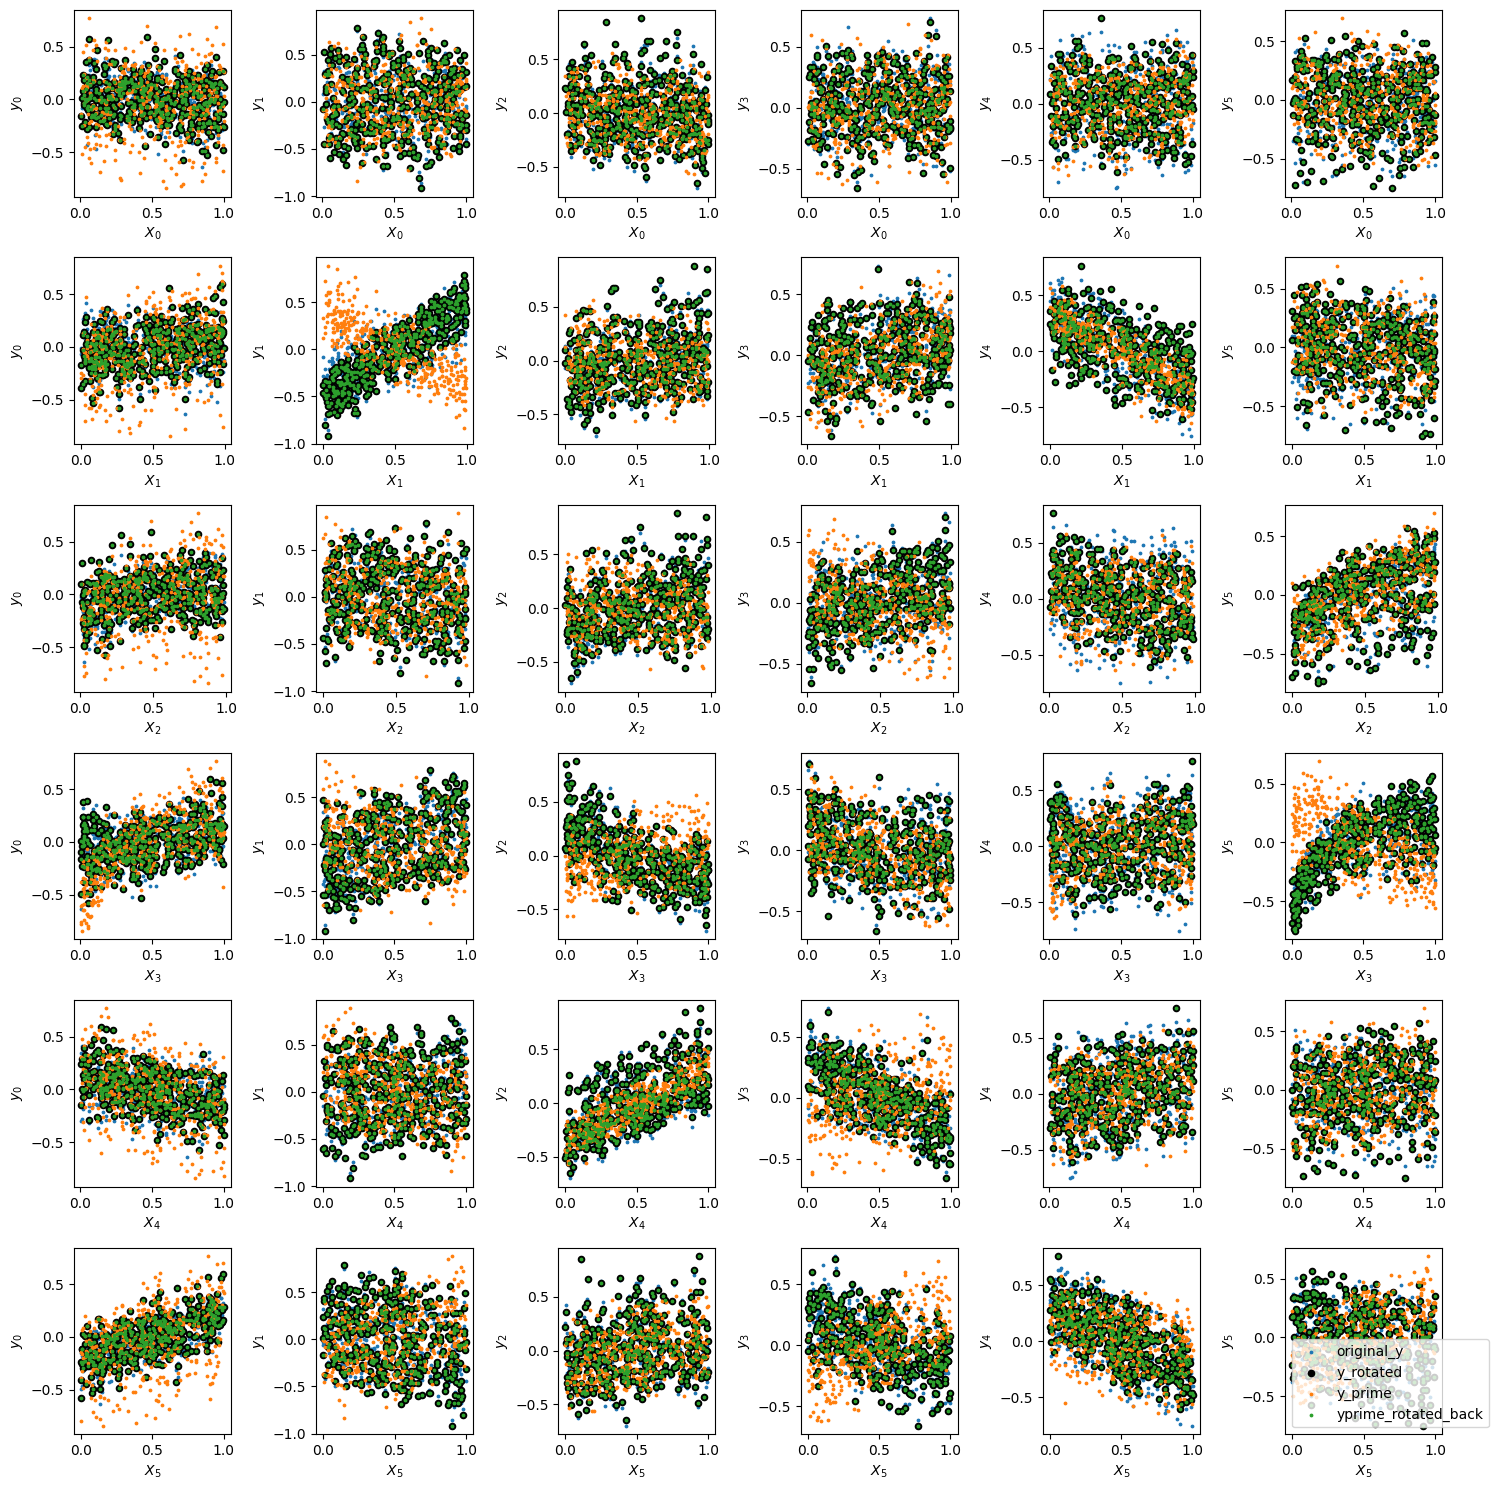

In [7]:

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='original_y', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_rot[::skip, j], label='y_rotated', s=20, c='k')
        axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='y_prime', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='yprime_rotated_back', s=3)


        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.legend()
plt.tight_layout()
plt.show()

thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.9944787   0.00356647  0.06793266 -0.02187576 -0.05167316  0.05688866]
 [-0.01111358  0.99684703  0.02481265 -0.0331779  -0.03798842  0.05488955]
 [-0.06740032 -0.02419583  0.99341494  0.08324312  0.00707659  0.03192094]
 [ 0.02427098  0.03268239 -0.08194572  0.9949539  -0.01989878  0.03604269]
 [ 0.04865292  0.03556158 -0.00624722  0.01469414  0.9959357   0.06500222]
 [-0.05822389 -0.05800916 -0.03379428 -0.0366427  -0.05960442  0.9935832 ]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.9090164  -0.23804368  0.24485286 -0.05067015  0.03596443  0.2306751 ]
 [ 0.17001662  0.94830227  0.15314057 -0.07256982  0.18086122  0.10192169]
 [-0.27800226 -0.06535327  0.9295653   0.05426718 -0.20978731  0.08600637]
 [

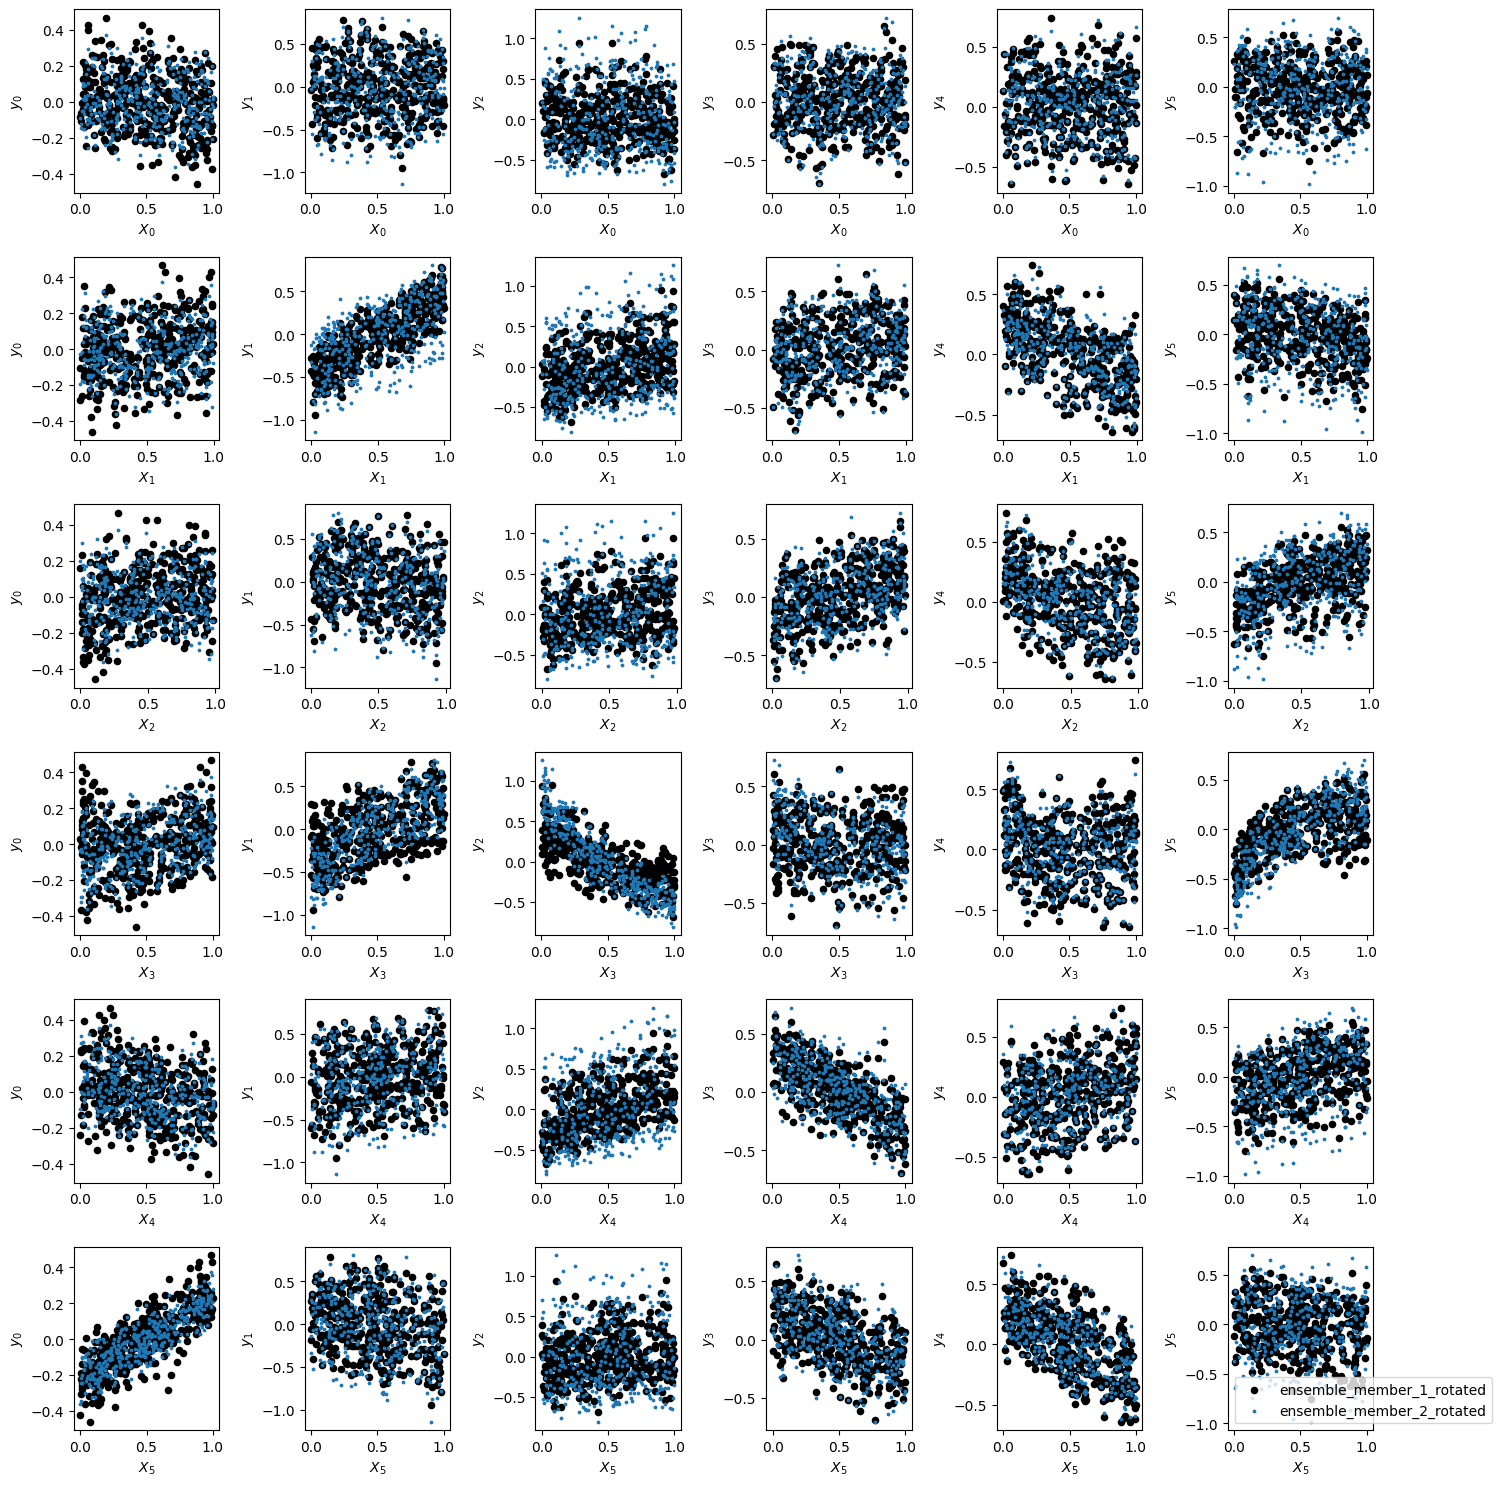

In [8]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = datafile['eta_ensemble'][17][randidx]

ytest_rot, *_ = rotate_coords(ytest, X, Favg, dys[0], y_reference= datafile['eta_ensemble'][2][randidx])

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = datafile['eta_ensemble'][0][randidx]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Favg, dys[0],  y_reference= datafile['eta_ensemble'][2][randidx])



fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_rot[::skip, j], label='ensemble_member_1_rotated', s=20, c='k')
        # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.legend()
plt.tight_layout()
plt.show()

thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.9570413   0.06492785 -0.1319162   0.03920451  0.11288533 -0.21948698]
 [-0.07215969  0.9908105  -0.03144842  0.02746065 -0.09562049 -0.04691616]
 [ 0.11424942  0.04855633  0.9861207  -0.03003813  0.10055074 -0.03379789]
 [-0.05064332 -0.03576877  0.03676138  0.99361753 -0.0174513  -0.08499553]
 [-0.16081774  0.07324167 -0.08829249  0.00402373  0.9721858  -0.12576242]
 [ 0.19335249  0.07125561 -0.00528034  0.097544    0.15017726  0.9619987 ]]
thetastar [0.6315514  0.44120693 0.54719007 0.44854033 0.4729259  0.46151984]
evalues [0.01339771 0.3781862  0.87145406 0.89741164 1.2455586  3.9272127 ]
rotmat [[ 0.9153108   0.17092279 -0.23977587 -0.04749557 -0.19314584 -0.18957296]
 [-0.2514061   0.9356085  -0.07035986  0.05486335 -0.22014993 -0.0707489 ]
 [ 0.20893526  0.13939485  0.9518564  -0.04159406  0.08653571 -0.14719506]
 [

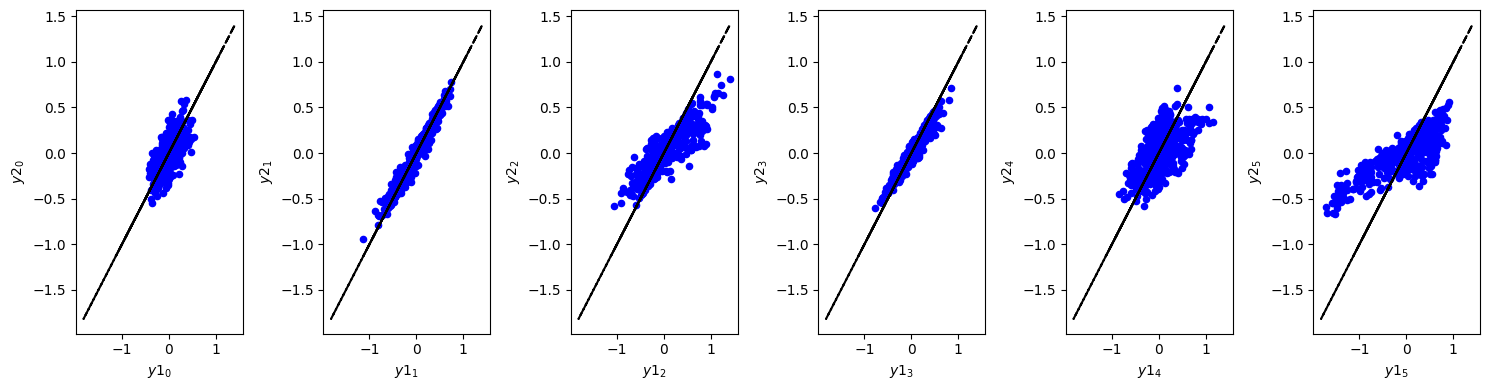

In [9]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = datafile['eta_ensemble'][3][randidx]

ytest_rot, *_ = rotate_coords(ytest, X, Favg, dys[0], y_reference= datafile['eta_ensemble'][0][randidx])

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = datafile['eta_ensemble'][6][randidx]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Favg, dys[0],  y_reference= datafile['eta_ensemble'][0][randidx])

# ytest_p_rot = ytest_p

fig, axs = plt.subplots(1, 6, figsize=(15,4))

skip=10

for i in range(X.shape[-1]):

        
    # row, column
    # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
    axs[i].scatter(ytest_rot[::skip,i], ytest_p_rot[::skip, i], label='ensemble_member_1_rotated', s=20, c='blue')
    axs[i].plot(ytest_rot, ytest_rot, c='k', ls='--')
    # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
    # axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


    axs[i].set_xlabel(r"$y1_%d$"%(i))
    axs[i].set_ylabel(r"$y2_%d$"%(i))

# plt.legend()
plt.tight_layout()
plt.show()

(array([432., 432., 371., 415., 429., 371., 429., 373., 394., 354.]),
 array([3.96490097e-04, 1.00311801e-01, 2.00227112e-01, 3.00142437e-01,
        4.00057733e-01, 4.99973059e-01, 5.99888384e-01, 6.99803710e-01,
        7.99718976e-01, 8.99634302e-01, 9.99549627e-01]),
 <BarContainer object of 10 artists>)

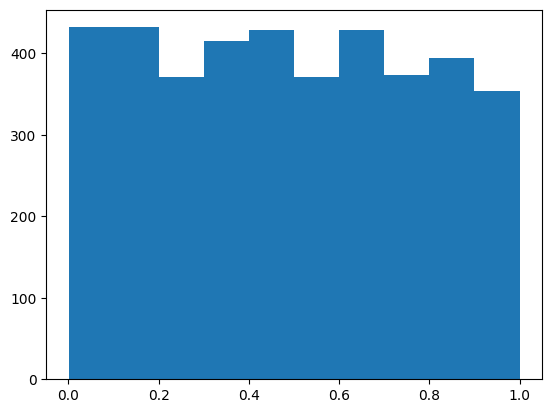

In [10]:
plt.hist(X[:, 2])

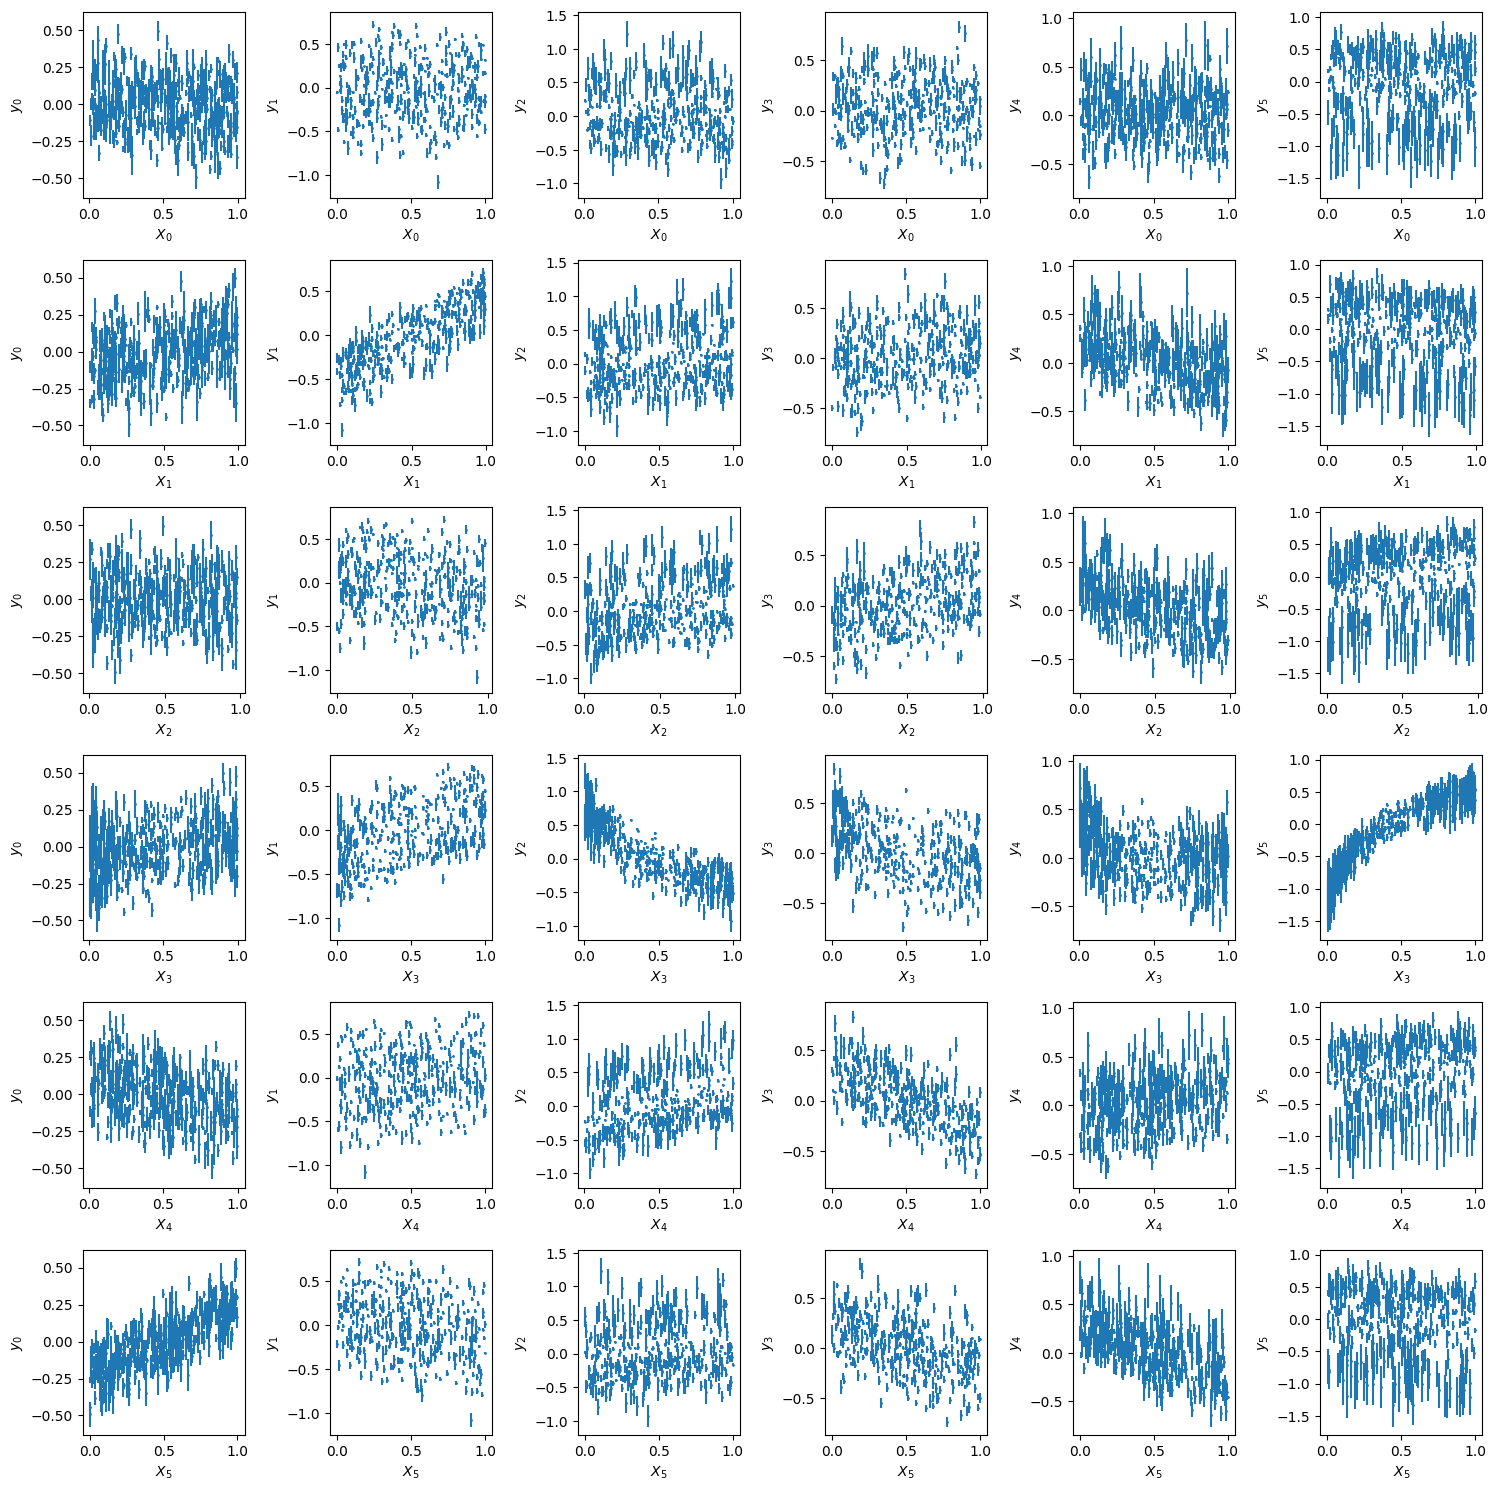

In [11]:
# create scatterplot to see how y responds to X

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        axs[i,j].errorbar(X[::skip,i], y[::skip, j], yerr=y_std[::skip, j], label='', fmt='o', markersize=1)

        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.tight_layout()
plt.show()

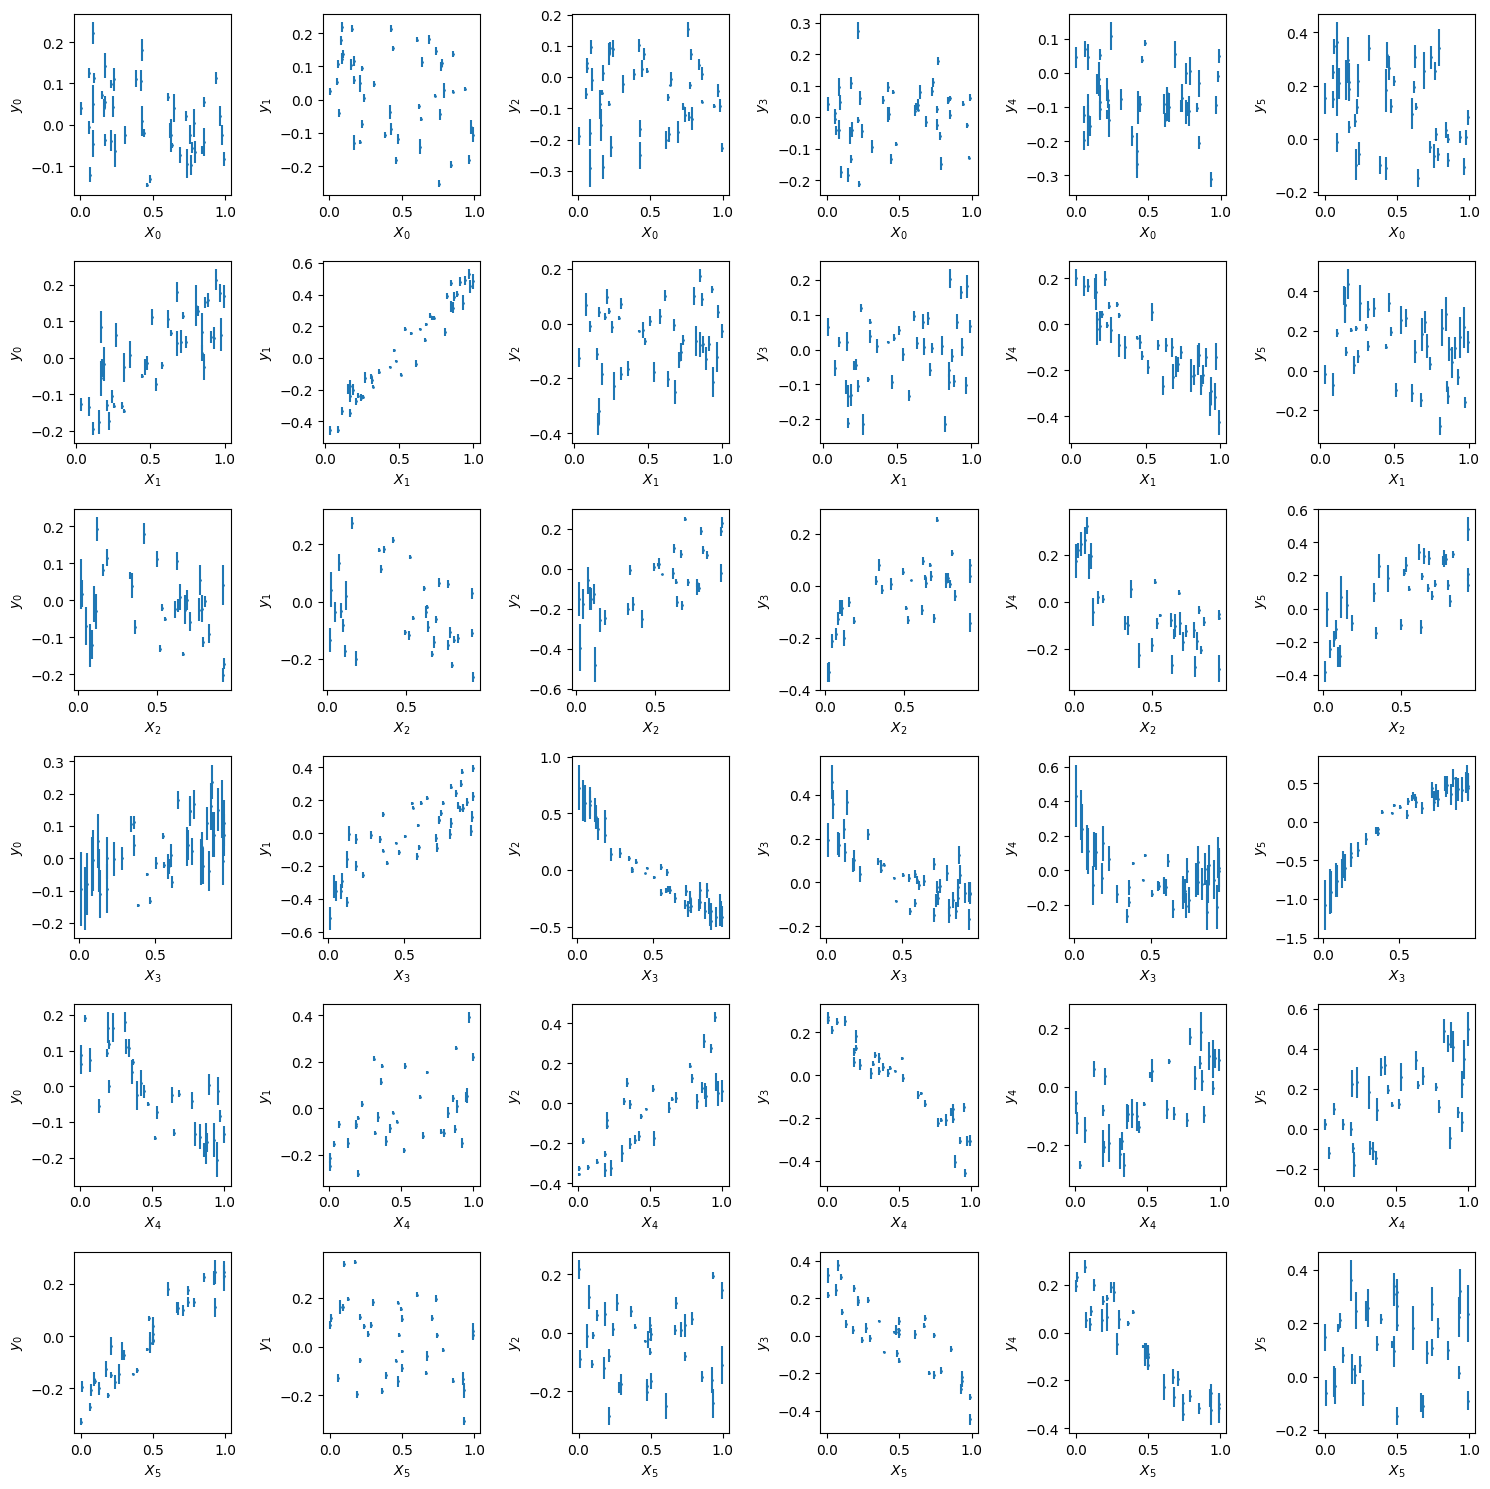

In [12]:
# plot within a small neighbourhood

fig, axs = plt.subplots(6, 6, figsize=(15,15))

skip=1

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):

        # mask close to the parameter value at hand
        eps = 0.2
        idxs = [l for l in np.arange(X.shape[-1]) if l != i ]

        msk = np.ones(X.shape[0]).astype(bool)

        fid = X.mean(0)
        fidmin = fid - eps
        fidmax = fid + eps

        for l in idxs:
            msk &= (X[:, l] > fidmin[l])
            msk &= (X[:, l] < fidmax[l])
        
        _x = X[msk]
        _y = y[msk]
        _yerr = y_std[msk]
        
        # row, column
        axs[i,j].errorbar(_x[::skip,i], _y[::skip, j], yerr=_yerr[::skip, j], label='', fmt='o', markersize=1)

        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.tight_layout()

In [13]:
delta = jnp.abs(X.max(0) -  X.min(0))
prior_norm = jnp.outer(delta, delta)
F_norm = Fs / prior_norm

C = F_norm.std(0) / (F_norm.mean(0) + prior_norm)
eigenval, eigenvec = np.linalg.eigh(C)

In [14]:
y[0]

array([ 0.0005457 ,  0.54133498, -0.38800245,  0.27099073,  0.05450578,
        0.45960443])

In [15]:
np.cov(y, rowvar=False).shape

Text(0, 0.5, '$y$')

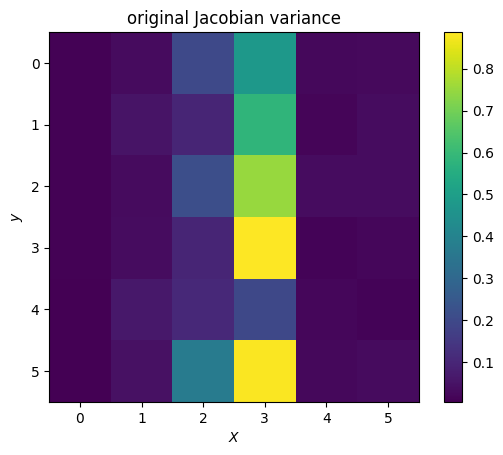

In [16]:
plt.imshow(dy.std(0))
plt.colorbar()
plt.title('original Jacobian variance')
plt.xlabel("$X$")
plt.ylabel("$y$")

Text(0, 0.5, '$y$')

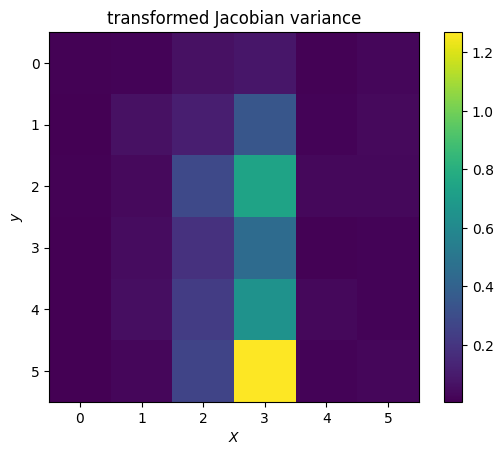

In [17]:
plt.imshow(dy_sr.std(0))
plt.colorbar()
plt.title('transformed Jacobian variance')
plt.xlabel("$X$")

plt.ylabel("$y$")

Text(0, 0.5, '$y$')

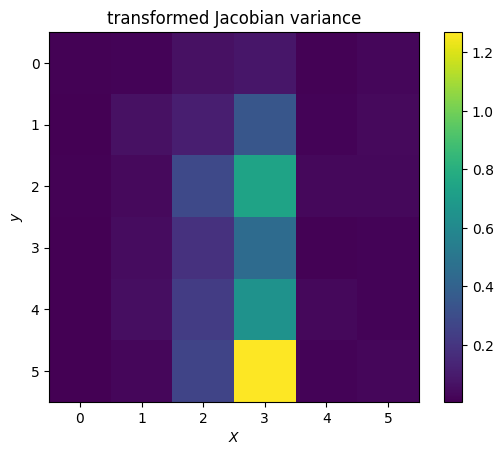

In [18]:
plt.imshow(dy_sr.std(0))
plt.colorbar()
plt.title('transformed Jacobian variance')
plt.xlabel("$X$")

plt.ylabel("$y$")

Text(0, 0.5, '$y$')

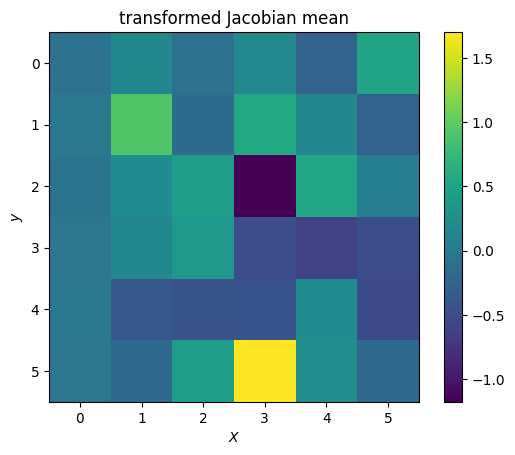

In [19]:
plt.imshow(dy_sr.mean(0))
plt.colorbar()
plt.title('transformed Jacobian mean')
plt.xlabel("$X$")
plt.ylabel("$y$")

In [20]:
np.dot(dy_sr[45, 0, :], dy_sr[45, 1, :])

0.040901437

Text(0, 0.5, '$y$')

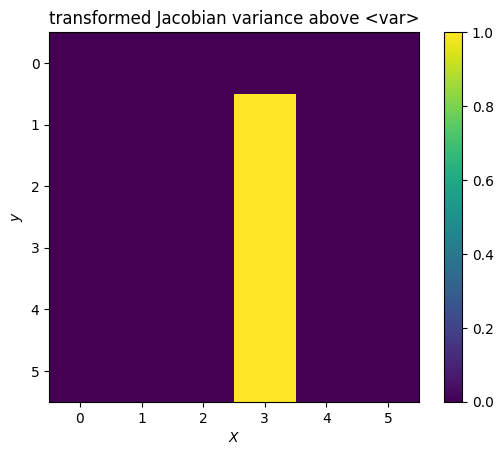

In [21]:
plt.imshow(dy_sr.var(0) > (dy_sr.var(0).mean()))
plt.colorbar()
plt.title('transformed Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

In [30]:
np.linalg.det(rotmat)

Text(0, 0.5, '$y$')

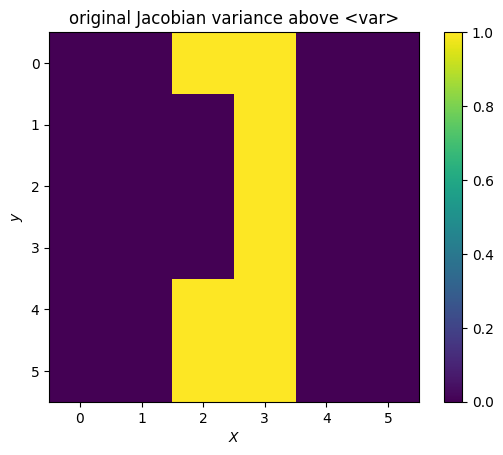

In [31]:
plt.imshow(dy.std(0) > (dy.std(0).mean()))
plt.colorbar()
plt.title('original Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

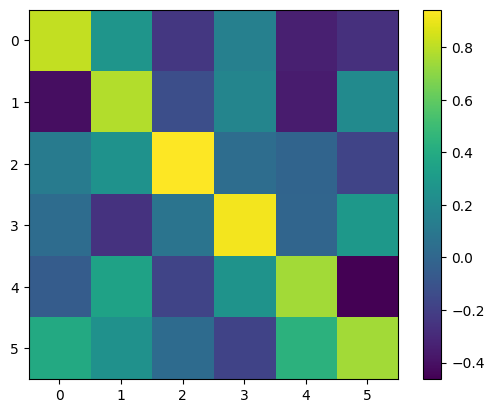

In [23]:
plt.imshow(rotmat)
plt.colorbar()

In [24]:
np.linalg.det(rotmat)

1.0000011

In [25]:
def flatten_with_numerical_jacobian(J_eta, F):
    Jeta_inv = jnp.linalg.inv(J_eta)
    Q = Jeta_inv.T @ F @ Jeta_inv
    return Q


def get_evalues(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    
    return eigenvalues[eigenvalues.argsort()]

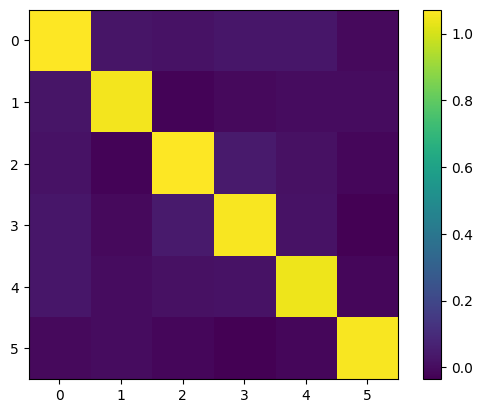

In [26]:
# foo = dy_sr / np.sqrt(0.5)
plt.imshow(jax.vmap(flatten_with_numerical_jacobian)(dy, Fs).mean(0))
plt.colorbar()

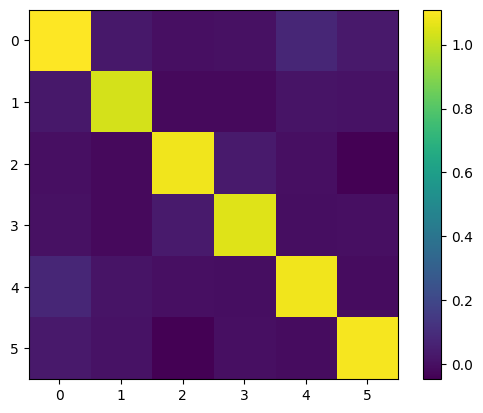

In [27]:
plt.imshow(jax.vmap(flatten_with_numerical_jacobian)(dy_sr, Fs).mean(0))
plt.colorbar()

In [28]:
# msk = (y_std[:, 0] != 0)
msk.shape

dy.shape

Text(0, 0.5, '$\\langle\\eta_{0,j}\\rangle$')

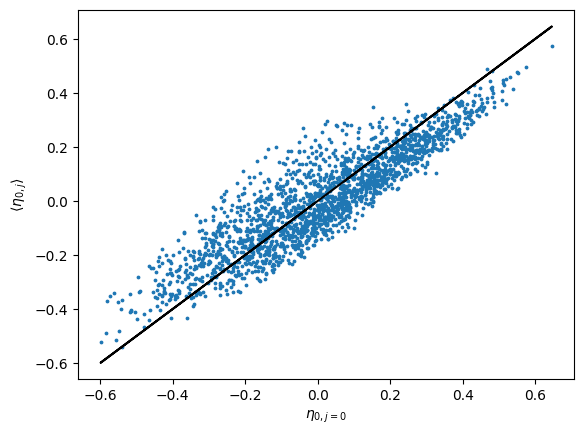

In [29]:
plt.scatter(ys[0, ::2, 0], np.average(ys[1:, ::2, 0], axis=0, \
                            weights=(ensemble_weights[1:])), s=3) 

plt.plot(ys[0, ::2, 0],ys[0, ::2, 0], c='k')
plt.xlabel(r"$\eta_{0,j=0}$")
plt.ylabel(r"$\langle\eta_{0,j}\rangle$")

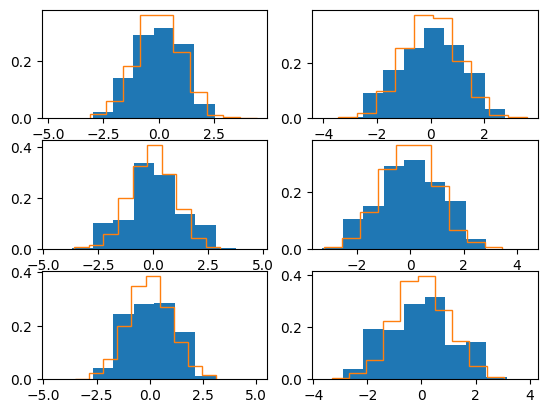

In [30]:
fig,axs = plt.subplots(3,2)
axs = axs.flatten()

for i,ax in enumerate(axs):
    ax.hist(((ys - y) / y_std)[:, :, i].flatten(), density=True)
    ax.hist(np.random.normal(size=(2000,)).flatten(), histtype='step', density=True)

In [31]:
(np.sqrt(np.linalg.det(Fs).mean()))

0.3984412

In [14]:
# Some parameters for operon
parent_dir = './fake_cmb_15_12/'


allowed_symbols = 'add,mul,pow,constant,variable,logabs,exp,sqrt,square' # logabs exp sqrt square
epsilon = 1e-5 # 1e-5
max_length = 25 #25 # 25
max_depth = 20 #10 # 8
time_limit = 60 * 2 # s
objectives=['r2', 'length'] #['rmse', 'length']#['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [33]:
# X -= X.mean(0) # try zero-centering


components_to_fit = [0, 1, 2, 3, 4, 5]


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = len(components_to_fit)

halfx = X.shape[0] // 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)


    Xfit = X[:halfx]
    yfit = y[:halfx, i]
    y_std_fit = y_std[:halfx]
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=10, # 1000
                max_length=max_length,
                max_depth=max_depth,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=1234,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                #max_time=int(time_limit),
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,
               #uncertainty=y_std_fit[:, i],
    )

    print("X train shape", Xfit.shape, "y train shape", yfit.shape)

    print('Fitting')
    reg.fit(Xfit, yfit) #, sample_weight = 1. / y_std_fit[:, i]**2.)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, Xfit)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

X train shape (2000, 6) y train shape (2000,)
Fitting
Done
((-0.24) + (3.91 * (0.13 * X6)))
{'model_length': 1, 'model_complexity': 3, 'generations': 910, 'evaluation_count': 0, 'residual_evaluations': 5711043, 'jacobian_evaluations': 3971972, 'random_state': 1234}
Outputting 22 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2000, 6) y train shape (2000,)
Fitting
Done
((-0.72) + (6.30 * ((0.08 * X4) + (0.15 * X2))))
{'model_length': 3, 'model_complexity': 7, 'generations': 839, 'evaluation_count': 0, 'residual_evaluations': 6045818, 'jacobian_evaluations': 3951362, 'random_state': 1234}
Outputting 23 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2000, 6) y train shape (2000,)
Fitting
Done
(0.08 + (1.00 * (((0.55 * X5) + ((-1.05) * X4)) + (0.37 * X3))))
{'model_length': 5, 'model_complexity': 11, 'generations': 1140, 'evaluation_count': 0, 'residual_evaluations': 7940069, 'jacobian_evaluations': 5217726, 'rando

7it [00:14,  2.10s/it]
8it [00:02,  3.07it/s]
8it [00:01,  4.36it/s]
8it [00:02,  3.89it/s]
8it [00:01,  5.12it/s]
10it [00:02,  4.29it/s]
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarni

In [15]:
# switch to validation set
X = X[halfx:]
y = y[halfx:]
y_std = y_std[halfx:]
dy = dy[halfx:]
dy_sr = dy_sr[halfx:]

Fs = Fs[halfx:]


In [16]:
Fs.shape, X.shape, y.shape, y_std.shape, dy_sr.shape

In [17]:
import jax
jax.config.update("jax_debug_nans", False)

In [18]:
import sympy

n_params = 6

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))


def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    component_idx = idx #components_to_fit[idx] # slot in the component that we're fitting in terms of where it falls in y vector

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)
        result = jnp.sum((y[:, component_idx] - ypred)**2 / 2 / y_std[:, component_idx]**2)
        return result
    


    
    # GET ROWS OF JACOBIAN AND CHECK FLATTENING per component
    def frob_loss(p):

        def get_jac_row(p):
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_row = get_jac_row(pars)
        # assign the SR expression's jacobian row to a copy of the network Jac
        jacobian = dy_sr.copy()
        jacobian[:, component_idx, :] = np.array(jac_row)

        def flatten_fisher(J, F):
            invJ = jnp.linalg.pinv(J)
            return invJ.T @ F @ invJ

        flats = jax.vmap(flatten_fisher)(jacobian, Fs)
        nn_flats = jax.vmap(flatten_fisher)(dy_sr, Fs)
        fn = lambda q: norm((q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(q) - jnp.eye(n_params)))

        return np.mean(jax.vmap(fn)(flats) - jax.vmap(fn)(nn_flats))
    


    neglogL = myloss(pars)
    frobloss = frob_loss(pars) # frob_loss_batched(pars) #  
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML) - np.sum(m) # subtract out sum of mask => params == 0
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, frobloss

In [19]:
outdir = parent_dir + "component_1/"
# Find what description length (arXiv:2211.11461, Eq. 6) gives
data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")
loss = np.array(data["mse"])
complexity = np.array(data["length"]) #[mse_mask]
max_complexity = complexity.max()

eqs = list(np.array(data['model'])) #[mse_mask])

In [20]:
components_to_fit = [0,1,2,3,4,5]

In [20]:
X.shape

In [776]:
''.join(['a', 'b', 'c'])

'abc'

In [40]:
parent_dir

'./fake_cmb_15_12/'

analysing 1 of 6 nonlinear components
fitting y component 0
7 equations below complexity threshold


7it [00:13,  1.87s/it]


Best equation: ((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))
Best frob loss equation: ((-0.000000) + (0.999965 * ((((-0.255094) * X5) + (-1.221468)) + (exp((0.186045 * X4)) + (0.504562 * X6)))))


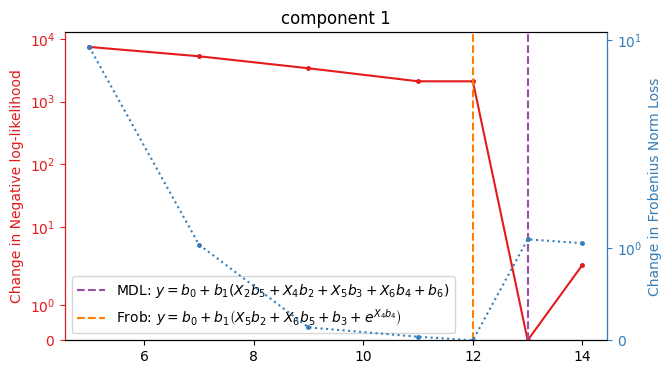

analysing 2 of 6 nonlinear components
fitting y component 1
8 equations below complexity threshold


8it [00:02,  3.31it/s]


Best equation: ((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))
Best frob loss equation: ((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))


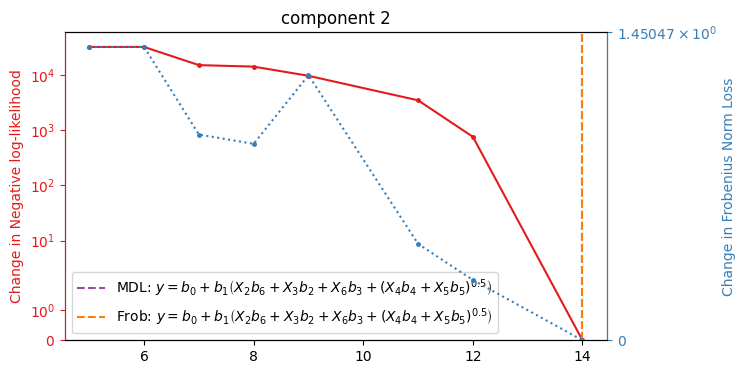

analysing 3 of 6 nonlinear components
fitting y component 2
8 equations below complexity threshold


8it [00:01,  4.70it/s]


Best equation: ((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))
Best frob loss equation: ((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))


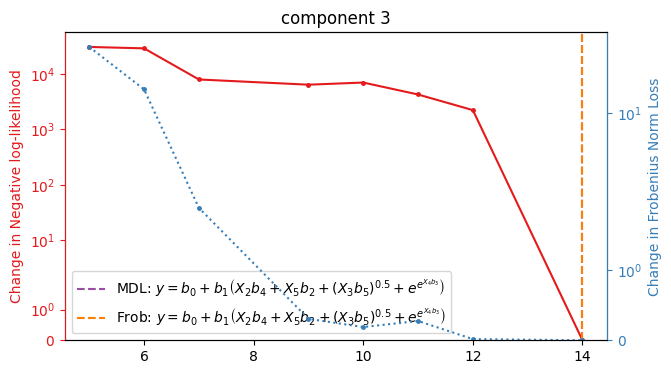

analysing 4 of 6 nonlinear components
fitting y component 3
8 equations below complexity threshold


8it [00:01,  4.55it/s]


Best equation: ((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))
Best frob loss equation: ((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))


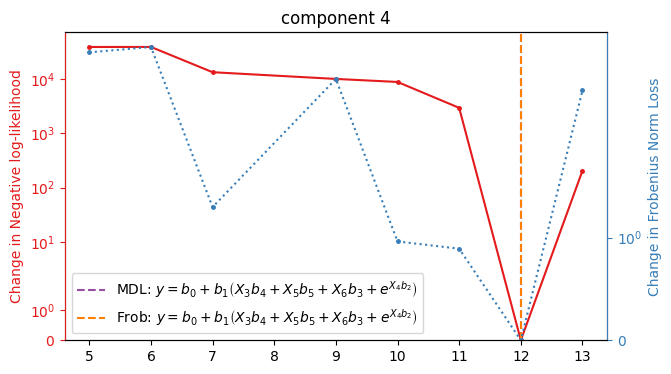

analysing 5 of 6 nonlinear components
fitting y component 4
8 equations below complexity threshold


8it [00:01,  4.96it/s]


Best equation: ((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))
Best frob loss equation: ((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))


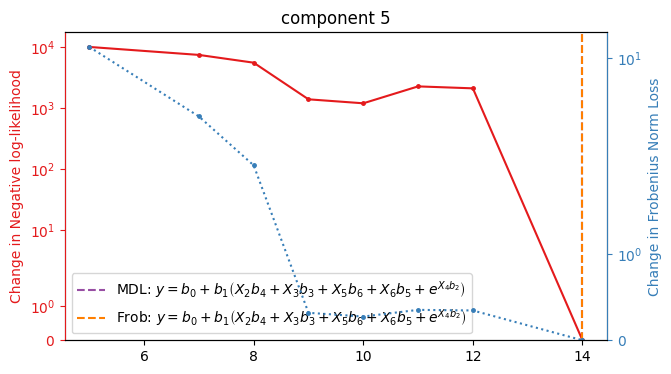

analysing 6 of 6 nonlinear components
fitting y component 5
10 equations below complexity threshold


10it [00:02,  3.90it/s]


Best equation: (0.410890 + ((-1.739578) * ((0.072790 * X6) + ((0.072790 * X5) + (((-0.210490) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4))))))))
Best frob loss equation: (0.420809 + ((-1.704589) * ((0.146736 * X6) + (((-0.189094) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4)))))))


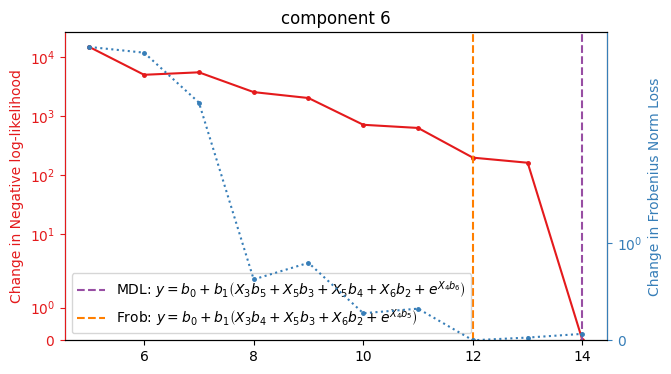

In [21]:
# components_to_fit = [0,1,2]

mdl_coordinates = []
frob_coordinates = []
mse_threshold = 15 # 10
n_components = len(components_to_fit)

both_comp_latex = []
both_comp_eqs = []
both_comp_frobloss = []
both_comp_logL = []
both_comp_DL = []


max_complexity_thresh = 15

for i in range(n_components):

    idx = components_to_fit[i]
    
    print("analysing %d of %d nonlinear components"%(i+1, n_components))
    print("fitting y component %d"%(idx))

    outdir = parent_dir + "component_%d/"%(i + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    #data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")

    data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]
 
    #mse_threshold = mse_thresholds[idx]
    loss = np.array(data["mse"])
    #mse_threshold = np.inf

    # mse_mask = (loss < mse_threshold)
    complexity = np.array(data["length"])
    mse_mask = (complexity < max_complexity_thresh)
    print("%d equations below complexity threshold"%(mse_mask.sum()))

    complexity = np.array(data["length"])[mse_mask]

    max_complexity = complexity.max()

    eqs = list(np.array(data['model'])[mse_mask])

    # chop some out to speed up code
    #eqs = eqs

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_frobloss = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in tq(enumerate(eqs)):
        c, all_latex[i], all_logL[i], all_DL[i], all_frobloss[i] = compute_DL(eq, idx)

    # set nans to infs
    all_DL[np.isnan(all_DL)] = np.inf
    all_logL[np.isnan(all_logL)] = np.inf
    all_frobloss[np.isnan(all_frobloss)] = np.inf



    # Only changes in DL and logL matter
    #all_DL -= np.amin(all_DL)
    #all_logL -= np.amin(all_logL)

    # unique complexities
    # complexity = np.sort(np.unique(complexity))[1:] # remove comp=1 e.g. constants


    # get best DL model at given complexity
    pareto_DL = []
    pareto_logL = [] 
    pareto_latex = []
    pareto_eqs = []
    pareto_frobloss = []
    comps = []
    for comp in np.unique(complexity):
        if comp > 1:
            mask = (complexity == comp)
            ibest_model_at_complexity = np.argmin(all_DL[mask])
            pareto_DL.append(all_DL[mask][ibest_model_at_complexity])
            pareto_logL.append(all_logL[mask][ibest_model_at_complexity])
            pareto_frobloss.append(all_frobloss[mask][ibest_model_at_complexity])
            pareto_latex.append(np.array(all_latex)[mask][ibest_model_at_complexity])
            pareto_eqs.append(np.array(eqs)[mask][ibest_model_at_complexity])
            comps.append(comp)

    # redfine kept complexities
    complexity = np.array(comps)

    pareto_DL = np.array(pareto_DL)
    pareto_DL -= np.amin(pareto_DL)

    pareto_logL = np.array(pareto_logL)
    pareto_logL -= np.amin(pareto_logL)

    pareto_frobloss = np.array(pareto_frobloss)
    pareto_frobloss -= np.amin(pareto_frobloss)

    # store the latex and eq
    both_comp_latex.append(pareto_latex)
    both_comp_eqs.append(pareto_eqs)
    both_comp_frobloss.append(pareto_frobloss)
    both_comp_DL.append(pareto_DL)
    both_comp_logL.append(pareto_logL)

    # Print the best found equation
    ibest = np.argmin(pareto_DL)
    print('Best equation:', pareto_eqs[ibest])
    mdl_coordinates.append(pareto_eqs[ibest])

    # Print the best frob loss equation
    ibest_frob = np.argmin(pareto_frobloss)
    print('Best frob loss equation:', pareto_eqs[ibest_frob])
    frob_coordinates.append(pareto_eqs[ibest_frob])


    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    
    #ax1.plot(complexity, pareto_DL, marker='.', color=cm(0), markersize=5, )
    # ax2.plot(complexity, pareto_logL, marker='.', color=cm(1), markersize=5, ls=':')
    ax1.plot(complexity, pareto_logL, marker='.', color=cm(0), markersize=5, )
    ax2.plot(complexity, pareto_frobloss, marker='.', color=cm(1), markersize=5, ls=':')


    #ax1.set_ylabel('Change in Description Length')
    # ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.set_ylabel('Change in Negative log-likelihood')
    ax2.set_ylabel('Change in Frobenius Norm Loss')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%pareto_latex[ibest])
    ax1.axvline(complexity[ibest_frob], color=cm(4), ls='--', label=r'Frob: $y = %s$'%pareto_latex[ibest_frob])

    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [22]:
mdl_coordinates

['((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))',
 '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
 '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
 '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
 '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
 '(0.410890 + ((-1.739578) * ((0.072790 * X6) + ((0.072790 * X5) + (((-0.210490) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4))))))))']

# post-process SR expressions

In [23]:
mdl_coordinates[0] + " + 1.0 * X5"

'((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194))))) + 1.0 * X5'

In [24]:
def replace_floats_nonlinear(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    nonlinear_functions = ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs", "^"]

    split_str = split_by_punctuation(s)
    values = []
    param_labels = []

    # values_nonlinear = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:

            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
            param_labels.append(split_str[i])

        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                param_labels.append(split_str[i]) # append param label for checking second deriv
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                param_labels.append(split_str[i])
                split_str[i+1] = ''
            


    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    

    # Rejoin string
    replaced = ''.join(split_str)


    # now go through and identify all of the linear terms
    linear_values = []
    linear_labels = []
    linear_indexes = []

    print(param_labels)

    for i,v in enumerate(values):

        ind = split_str.index(f'b{i}')
        p = split_str[ind]

        # calculate derivative wrt paramter p
        derv = sympy.Derivative(sympy.Derivative(str(replaced), p, evaluate=True), p, evaluate=True)

        if str(derv) == "0":
            linear_values.append(values[i])
            linear_labels.append(p)
            linear_indexes.append(i)


    return replaced, values, linear_values, linear_labels, linear_indexes

In [25]:
def get_component(eq, idx):

    component_idx = idx #components_to_fit[idx] # slot in the component that we're fitting in terms of where it falls in y vector

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    # expr, pars = replace_floats(eq)
    # print(expr)
    # _oldexpr = expr

    # expr = str(sympy.expand(eq))
    expr = str(eq)
    _oldexpr = expr

    expr, pars, linear_pars, linear_par_names, linear_indexes = replace_floats_nonlinear(str(expr))

    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )

    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    # eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])
    eq_numpy = sympy.lambdify(all_b + all_x, expr, modules=["numpy"])


    linear_b = list(sympy.symbols(linear_par_names, real=True))


    # put the pars and values in a dictionary

    param_dict = dict(
                    labels=labels,
                    expr=expr,
                    linear_b=linear_b,
                    linear_pars=linear_pars,
                    pars=pars,
                    all_b=all_b,
                    all_x=all_x,
                    eq_numpy=eq_numpy,
                    linear_indexes=linear_indexes
    )


    return labels, expr, np.array(pars), np.array(linear_pars), all_x, all_b, eq_numpy, param_dict, linear_indexes

    # def myloss(p):
    #     ypred = eq_jax(*p, *X.T)
    #     result = jnp.sum((y[:, component_idx] - ypred)**2 / 2 / y_std[:, component_idx]**2)
    #     return result
    

In [26]:
labels, expr, pars, linear_pars, all_x, all_b, eq_numpy, param_dict, linear_indexes = get_component(mdl_coordinates[2], 2)

['b0', 'b1', 'b2', 'b3', 'b4', 'b5']


In [27]:
type(param_dict['linear_b'][0])

sympy.core.symbol.Symbol

In [28]:
labels, expr, pars, linear_indexes

(['Add',
  'b0',
  'Mul',
  'b1',
  'Add',
  'Sqrt',
  'Mul',
  'X3',
  'b5',
  'Add',
  'Mul',
  'X2',
  'b4',
  'Add',
  'Mul',
  'X5',
  'b2',
  'exp',
  'exp',
  'Mul',
  'X4',
  'b3'],
 b0 + b1*(X2*b4 + X5*b2 + (X3*b5)**0.5 + exp(exp(X4*b3))),
 array([-2.175624,  0.852304,  0.657605, -1.207325,  0.243478,  0.180595]),
 [0, 1, 2, 4])

In [28]:
expr = "b0 + b1*exp(b2**X1)"
testfn = sympy.lambdify(["b0, b1", "X1"], expr)

In [230]:
np.logaddexp(0, 7)

In [1987]:
all_linear_pars

[array([-0.      ,  1.      ,  0.204857, -0.25681 ,  0.505997,  0.16501 ,
        -0.308194]),
 array([-0.766542,  1.00545 , -0.146338, -0.279673,  0.921615]),
 array([-2.175624,  0.852304,  0.657605,  0.243478]),
 array([-0.001738,  0.635467, -0.771097,  0.516828, -0.927204]),
 array([-0.078065,  0.810098, -0.496046, -0.492361, -0.645588,  0.258904]),
 array([ 0.41089 , -1.739578,  0.07279 ,  0.07279 , -0.21049 , -0.21049 ])]

In [93]:
from copy import deepcopy

def get_linear_par_index(linear_pars):
    linear_pars_flat = [p for ps in linear_pars for p in ps]

    idx_par = np.arange(len(linear_pars_flat)) # full flattened tree index

    lengths = [len(ps) for ps in linear_pars]

    idx_par_shaped = []
    total_length = 0
    for i,ps in enumerate(linear_pars):
        idx = total_length
        idx_par_shaped.append(list(idx_par[idx:idx+lengths[i]]))
        total_length += lengths[i]
    
    return linear_pars_flat, idx_par_shaped # indexed by (param_idx, position_in_original_row_expr)

def construct_M(linear_pars):

    linear_pars_flat, idx_par_shaped = get_linear_par_index(linear_pars)
    
    M = np.zeros((X.shape[-1], len(linear_pars_flat)))

    # print(M.shape)
    for i,p in enumerate(linear_pars): # this is 1->n_params
        # flattened index
        for j,l in enumerate(p):
            M[i, idx_par_shaped[i][j]] = l

    return M


def get_Q(M):
    M_strict = np.tril(M, k=-1)
    # Make matrix with exponentiated diagonal
    D = np.diag(M)
    # Make the Cholesky decomposition matrix
    L = M_strict + np.diag(np.logaddexp(0, D))
    # Invert the Cholesky decomposition
    Sigma = np.matmul(L, L.T)
    return Sigma


def get_ortho(A):
    A = 0.5 * (A - A.T)
    return scipy.linalg.expm(A)


def lossfn(A, all_pars, all_fns, linear_pars, linear_indexes, parts=False):
    # t_i = LINEAR expression wrt X_i, f(X_i)
    # M_i = pars --> numerical parameters

    A = A.reshape((6,6))

    #A = get_ortho(A)
    #A = get_Q(A)

    lp = [p for p in linear_pars]
    M = construct_M(linear_pars)
    linear_pars_flat, idx_par_shaped = get_linear_par_index(linear_pars)
    
    ooft = A @ M

    # need to feed in these new coeffs into the pars
    altered_pars = []
    for i,pm in enumerate(all_pars):
        pm2 = deepcopy(pm)
        for j,l in enumerate(linear_pars[i]):
            
            #print(type( idx_par_shaped[i][j]))
            pm2[linear_indexes[i][j]] = ooft[i, idx_par_shaped[i][j]]

        altered_pars.append(pm2)

    # get new predictions by going through all linear terms
    ypreds_prime = []

    # loop through 6 new parameters
    for l in range(A.shape[0]):
        y_l = 0
        for i in range(A.shape[0]):
            p = altered_pars[i]
            y_l += all_fns[i](*p, *X.T)

        ypreds_prime.append(y_l)

    ypreds_prime = np.array(ypreds_prime)

    #ypreds_prime = np.array([all_fns[i](*p, *X.T) for i,p in enumerate(altered_pars)]) # was all_pars

    # get old predictions
    ypreds = np.array([all_fns[i](*p, *X.T) for i,p in enumerate(all_pars)]) # was all_pars
    
    # ypreds = y.T # network outputs

    # print(ypreds.shape)

    yprime_inv = np.einsum("ij,jb->bi", np.linalg.pinv(A), ypreds_prime)

    #Xprime = np.einsum("ij,jb->bi", np.linalg.inv(A), ypreds_prime)

    #part2 = np.linalg.norm((X - Xprime)) # 
    part1 = 0.1 * np.abs(ooft).sum()
    #part2 = np.linalg.norm((yprime_inv - ypreds.T)) # 

    # try likelihood
    # part2 = ((yprime_inv - ypreds.T)**2 / 2. / y_std**2).sum()
    
    part2 = ((yprime_inv - ypreds.T)**2).mean() #np.linalg.norm((yprime_inv - ypreds.T))
    #part3 = 1.0 * (np.trace((A.T @ A)) - 3)**2
    part3 = 100*np.linalg.norm((A.T @ A) - np.eye(n_params)) #+ np.linalg.norm((np.linalg.inv(A) @ A) - np.eye(n_params))

    # ensure we have some weights in each row:
    part4 = 0.0 #0.5 * ((np.abs(ooft).sum(-1) - 1)**2).sum() # was 0.5

    

    if parts:
        return  part1, part2, part3, part4

    else:
        return (part1 + part2 + part3 + part4) # (np.linalg.det(A) - 1)**2 +




def get_pruned_coeffs(A, all_pars, linear_pars):
    A = A.reshape((6,6))

   # A = get_Q(A)
    # stack coeffs into matrix padded to maximum length
    # _maxlen = np.max(np.array([len(p) for p in linear_pars]))
    # M = np.zeros((X.shape[-1], _maxlen))
    lp = [p for p in linear_pars]
    M = construct_M(linear_pars)
    ooft = A @ M
    # # set some threshold for throwing out a param
    threshold = 1e-3

    for i,p in enumerate(all_pars):
        upto = len(p)
        ooft[i, upto:] = 0
    return ooft



def get_pruned_expressions(A, 
                           param_dicts,
                           all_pars, 
                           linear_pars, 
                           all_expressions, 
                           linear_labels,
                           remove_floats=True,
                           threshold=1e-2):
    A = A.reshape((6,6))

    #A = get_Q(A)

    # stack coeffs into matrix padded to maximum length
    _, idx_par_shaped = get_linear_par_index(linear_pars)
    M = construct_M(linear_pars)
    
    ooft = A @ M

    # go through expressions and split and replace with floats to simplify

    new_expressions = []
    new_constants = []

    print(ooft.shape)

    for l in range(A.shape[0]):

        replaced = []
    
        for i,eq in enumerate(all_expressions):
            eq = str(eq)
            split_str = split_by_punctuation(eq)

            all_labels = param_dicts[i]["all_b"]


            # go through each LINEAR parameter
            for j,p in enumerate(linear_labels[i]):

            
                ind = split_str.index(str(p))

                value = ooft[l, idx_par_shaped[i][j]]

                #_lossfn = lambda a: lossfn(a, all_pars, all_fns, all_linear_pars, all_linear_inds)

                if np.abs(value) < threshold:
                    value = 0.0
                split_str[ind] = str(value)

            # then go through the rest of the parameter labels and replace floats with parameter values
            for j,p in enumerate(all_labels):
                

                if p not in linear_labels[i]:
                    ind = split_str.index(str(p))
                    value = all_pars[i][j]

                    # replace string with value
                    split_str[ind] = str(value)



            # then simplify the expre3ssion and do some rounding
            split_str = ''.join(split_str)
            split_str = str(sympy.simplify(str(split_str)))
            replaced.append(split_str)


        replaced = '+'.join(replaced)
        replaced = sympy.simplify(str(replaced))

        # go through and round to nice decimals
        replaced1 = replaced
        for a in sympy.preorder_traversal(replaced1):
            if isinstance(a, sympy.Float):
                replaced = replaced.subs(a, round(a, 2))
        #print(ex1)  # original
        #print(ex2)  # rounded


        if remove_floats:
            replaced = sympy.simplify(str(replaced))
            replaced,new_values = replace_floats(str(replaced))

        else:
            replaced = sympy.simplify(str(replaced))
            _,new_values = replace_floats(str(replaced))
            replaced = str(replaced)

        # do thresholding thing
        new_expressions.append(replaced)
        new_constants.append(new_values)

    #print(new_constants)
    

    return new_expressions, new_constants

In [30]:
# here we want to threshold based on how the loss function responds to a delta_p shift, where p is a linear coefficient

def thresholding(values, split_string, threshold = 1e-2, delta=0.1):
    new_values = []
    for i,v in enumerate(values):

        ind = split_string.index(f'b{i}')
        p = split_string[ind]

        #print("p", p)
        # calculate derivative wrt paramter p
        second_derv = str(sympy.Derivative(sympy.Derivative(''.join(split_string), p, evaluate=True), p, evaluate=True))

        #derv = str(sympy.Derivative(''.join(replaced), p, evaluate=True))

        #print('derv', derv)
        
        b_list = [f"b{i}" for i in range(len(values))]
        _all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
        _all_x = list(sympy.symbols(_all_x, real=True))
        _all_b = list(sympy.symbols(b_list, real=True))

        #print('values', values)
        second_drv_value = np.array(sympy.lambdify(_all_b + _all_x, second_derv, modules=['numpy'])(*values, *list(X.T))).astype(float)

        if second_drv_value < v:
            new_values.append(0.0)
        else:
            new_values.append(v)

    return new_values



### demo


In [2214]:
len(mdl_coordinates[0].split("X6"))

In [128]:
mdl_coordinates

['((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))',
 '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
 '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
 '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
 '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
 '(0.410890 + ((-1.739578) * ((0.072790 * X6) + ((0.072790 * X5) + (((-0.210490) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4))))))))']

In [129]:
np.random.randn()* 0.1

In [135]:
# _lens = [len(m.split("X%d"%(j+1))) for j in range(6) for m in mdl_coordinates ]

# _lens

pars_to_append = []

for j in range(6):
    parstring = "X%d"%(j+1)

    _lens = np.array([len(m.split(parstring)) for m in mdl_coordinates])

    par_present = (_lens < 2).sum()

    if par_present == n_params:
        pars_to_append.append(" + (%.2f * "%(np.random.randn()) + parstring + ")")


print(pars_to_append)

[' + (-0.15 * X1)']


In [136]:
# add in all the X_i as extra columns to fit for in a linear combination

extra_bit = "".join([" + 0.01 * X%d"%(j) for j in range(n_params)])

mdl_coords_mod = deepcopy(mdl_coordinates)

#mdl_coords_mod[-1] += extra_bit

# mdl_coords_mod = [mdl_coords_mod[j].join(" + 0.01 * X%d"%(j)) for j in range(n_params)]

# for j in range(n_params):
    # mdl_coords_mod[j] += " + 0.01 * X%d"%(j)


for j in range(len(pars_to_append)):
    mdl_coords_mod[0] += pars_to_append[j]

In [137]:
mdl_coords_mod[0]

'((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194))))) + (-0.15 * X1)'

In [138]:
mdl_coords_mod[0]

'((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194))))) + (-0.15 * X1)'

In [139]:
all_pars = []
all_linear_pars = []
all_fns = []
all_linear_inds = []
all_param_dicts = []

all_expr = []

all_linear_labels = []

for i in range(6):
    # lab, expr, prs, _x, _b, eq_fn, oldexpr, nodes = get_component(mdl_coordinates[i], i)

    lab, expr, prs, linear_prs, _x, _b, eq_fn, param_dict, linear_inds = get_component(mdl_coords_mod[i], i)
    all_pars.append(prs)
    all_linear_pars.append(linear_prs)
    all_fns.append(eq_fn)
    all_linear_inds.append(linear_inds)
    all_param_dicts.append(param_dict)
    all_expr.append(expr)

    all_linear_labels.append([_b[l] for l in linear_inds])



['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6']
['b0', 'b1', 'b2', 'b3', 'b4', 'b5']
['b0', 'b1', 'b2', 'b3', 'b4', 'b5']
['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6']
['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6']


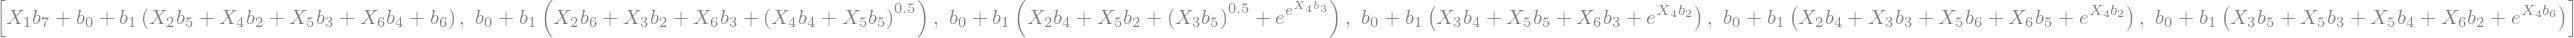

In [140]:
all_expr

In [141]:
from scipy.optimize import minimize

np.random.seed(33)

Ainit = (np.random.normal(size=(6,6))) * (2./36.) # he initialisation
# Ainit = 0.5 * (Ainit - Ainit.T)

# Ainit = np.eye(6)

#Ainit = get_Q(Ainit)

_lossfn = lambda a: lossfn(a, all_pars, all_fns, all_linear_pars, all_linear_inds)
res = minimize(_lossfn, x0=Ainit.flatten(), tol=1e-5, method='BFGS', options=dict(maxiter=1e7))

Aopt = (res.x.reshape((6,6)))



In [2313]:
# Aopt = get_Q(Aopt)

In [142]:
np.linalg.det((Aopt.T @ Aopt))

In [143]:
Aopt @ np.linalg.inv(Aopt)

array([[ 1.00000000e+00, -5.36077520e-17,  3.62529522e-17,
        -2.24646938e-18, -3.65691416e-17,  1.68269892e-16],
       [ 7.84042709e-18,  1.00000000e+00,  3.75611056e-17,
         5.23097252e-17, -1.07394054e-16, -1.41536171e-17],
       [ 1.43969820e-17, -2.12756734e-17,  1.00000000e+00,
         2.38719425e-17, -1.51730804e-17, -1.04043544e-17],
       [-2.44786660e-18, -2.65270384e-17, -6.17086768e-18,
         1.00000000e+00, -5.71205230e-17,  1.00832178e-17],
       [-3.48845682e-17, -1.43922939e-17, -4.06636455e-18,
         1.61034560e-17,  1.00000000e+00,  6.45121836e-18],
       [ 1.96463031e-17, -3.34440031e-17,  9.23087590e-18,
         1.27159333e-17, -3.18917245e-17,  1.00000000e+00]])

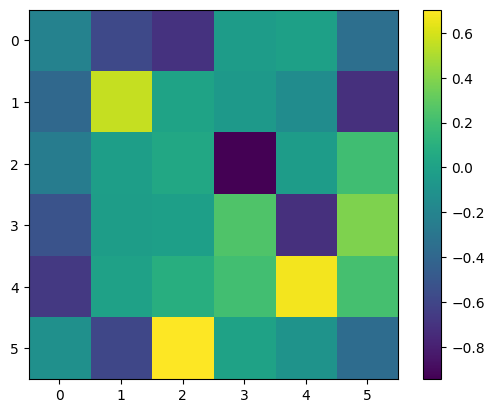

In [144]:
plt.imshow((Aopt))
plt.colorbar()

In [145]:
_lossfn = lambda a: lossfn(a, all_pars, all_fns, all_linear_pars, all_linear_inds, parts=True)

_lossfn(Aopt), _lossfn(np.eye(6))

In [146]:
(Aopt @ construct_M(all_linear_pars)).shape

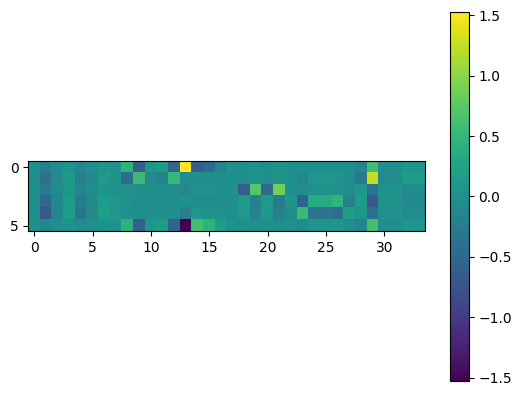

In [147]:
plt.imshow((Aopt @ construct_M(all_linear_pars)))
plt.colorbar()

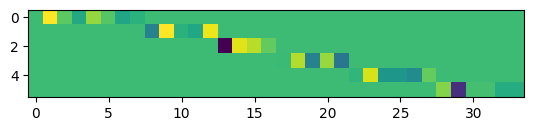

In [148]:
plt.imshow(construct_M(all_linear_pars))

In [149]:
get_pruned_expressions(np.eye(6), 
                      all_param_dicts,
                       all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=True, threshold=1e-20
                       )


(6, 34)


(['b0*X1+b1*X2+b2*X4-b3*X5+b4*X6-b5',
  'b0*X2-b1*X3-b2*X6+b3*(X4+b4*X5)**b5-b6',
  'b0*X2+b1*X3**b2+b3*X5+b4*exp(exp(b5*X4))-b6',
  'b0*X3-b1*X5-b2*X6+b3*exp(b4*X4)',
  'b0*X2-b1*X3+b2*X5-b3*X6-b4+b5*exp(b6*X4)',
  'b0*X3+b1*X5-b2*X6+b3-b4*exp(b5*X4)'],
 [[-0.15, 0.17, 0.2, 0.26, 0.51, 0.31],
  [0.93, 0.15, 0.28, 0.72, 0.11, 0.5, 0.77],
  [0.21, 0.36, 0.5, 0.56, 0.85, -1.21, 2.18],
  [0.33, 0.59, 0.49, 0.64, -1.17],
  [-0.4, 0.4, 0.21, 0.52, 0.08, 0.81, -0.53],
  [0.37, 0.24, 0.13, 0.41, 1.74, -2.48]])

In [150]:
fit_exprs, _ = get_pruned_expressions(Aopt, all_param_dicts,
                  all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=False, threshold=0.1
                       )

(6, 34)


In [151]:
fit_exprs

['0.42*X2 - 0.25*X3**0.5 + 0.28*X5 - 0.07*X6 - 0.42*(X4 + 0.11*X5)**0.5 - 0.6*exp(exp(-1.21*X4)) + 1.84 + 0.59*exp(-2.48*X4)',
 '0.29*X2 + 0.19*X3 + 0.15*X5 + 0.4*(X4 + 0.11*X5)**0.5 - 0.77 + 1.25*exp(-2.48*X4) - 0.11*exp(-0.53*X4)',
 '0.29*X3 - 0.53*X5 - 0.41*X6 - 0.35*exp(-2.48*X4) - 0.6*exp(-1.17*X4)',
 '-0.21*X2 - 0.19*X3 + 0.06*X4 - 0.16*X6 + 0.08 - 0.67*exp(-2.48*X4) + 0.16*exp(-1.17*X4) - 0.58*exp(-0.53*X4)',
 '0.1*X1 - 0.11*X2 - 0.17*X3 + 0.09*X4 - 0.05*X5 - 0.03*X6 - 0.33 - 0.38*exp(-2.48*X4) + 0.13*exp(-1.17*X4) + 0.54*exp(-0.53*X4)',
 '0.43*X2 + 0.25*X3**0.5 + 0.28*X5 - 0.1*X6 - 0.43*(X4 + 0.11*X5)**0.5 + 0.6*exp(exp(-1.21*X4)) - 1.23 + 0.63*exp(-2.48*X4)']

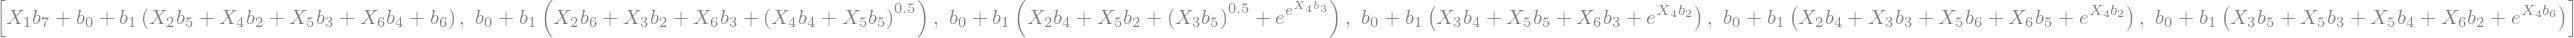

In [2234]:
all_expr

In [122]:
mdl_coordinates

['((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))',
 '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
 '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
 '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
 '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
 '(0.410890 + ((-1.739578) * ((0.072790 * X6) + ((0.072790 * X5) + (((-0.210490) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4))))))))']

In [2136]:
from sympy import init_printing
init_printing()


def output_latex_table(idx, headers=False):
    to_print = ["$" + q + "$" for q in both_comp_latex[idx]]
    outs = ""

    if headers:
        outs += "\\textbf{COMPONENT %d}\n \n"%(idx+1) + "\\begin{tabular}{l|l} \nFrob loss & Equation \\\ \n \\hline \n"

    for i,t in enumerate(to_print):
        outs += "%.2f"%(both_comp_frobloss[idx][i]) + " & " +  t + " \\\ \n"

    if headers:
        outs += "\n\\end{tabular}" + "\n \\newpage"

    return outs


all_outs = []
for i in range(len(components_to_fit)):
    outs1 = output_latex_table(i, True)
    all_outs.append(outs1)

    print(outs1)

\textbf{COMPONENT 1}
 
\begin{tabular}{l|l} 
Frob loss & Equation \\ 
 \hline 
9.09 & $X_{6} b_{1} b_{2} + b_{0}$ \\ 
1.04 & $b_{0} + b_{1} \left(X_{5} b_{2} + X_{6} b_{3}\right)$ \\ 
0.14 & $b_{0} + b_{1} \left(X_{4} b_{2} + X_{5} b_{3} + X_{6} b_{4}\right)$ \\ 
0.04 & $b_{0} + b_{1} \left(X_{4} b_{2} + X_{5} b_{3} + X_{6} b_{5} + b_{4}\right)$ \\ 
0.00 & $b_{0} + b_{1} \left(X_{5} b_{2} + X_{6} b_{5} + b_{3} + e^{X_{4} b_{4}}\right)$ \\ 
1.10 & $b_{0} + b_{1} \left(X_{2} b_{5} + X_{4} b_{2} + X_{5} b_{3} + X_{6} b_{4} + b_{6}\right)$ \\ 
1.05 & $b_{0} + b_{1} \left(X_{2} b_{5} + X_{5} b_{2} + X_{6} b_{4} + b_{3} + e^{X_{4} b_{6}}\right)$ \\ 

\end{tabular}
 \newpage
\textbf{COMPONENT 2}
 
\begin{tabular}{l|l} 
Frob loss & Equation \\ 
 \hline 
1.38 & $X_{2} b_{1} b_{2} + b_{0}$ \\ 
1.38 & $b_{0} + b_{1} e^{X_{2} b_{2}}$ \\ 
0.97 & $b_{0} + b_{1} \left(X_{2} b_{3} + X_{4} b_{2}\right)$ \\ 
0.93 & $b_{0} + b_{1} \left(X_{2} b_{3} + \left(X_{4} b_{2}\right)^{0.5}\right)$ \\ 
1.25 & $b_{

In [114]:
def check_flattening(coordinates, return_J=True, A=jnp.eye(6)):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                }
    
    
    jac_rows = []
    
    for eq in coordinates:
        expr, pars = replace_floats(eq)
        expr, nodes, c = esr.generation.generator.string_to_node(
            expr, 
            basis_functions, 
            evalf=True, 
            allow_eval=True, 
            check_ops=True, 
            locs=sympy_locs
        )
        param_list = [f"b{i}" for i in range(len(pars))]
        labels = nodes.to_list(basis_functions)
        latex_expr = sympy.latex(expr)
        
        # klog(n) + \sum_i log |c_i|
        aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
        
        # Turn function into callable object
        all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
        all_x = list(sympy.symbols(all_x, real=True))
        all_b = list(sympy.symbols(param_list, real=True))
        eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])

        def get_jac_row(p):
            
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_rows.append(get_jac_row(pars))

   # Jpred = jnp.stack(jac_rows, axis=-1).transpose((0, 2, 1))
    # Jpred = dy_sr.copy()
    # for r in range(len(jac_rows)):
    #     Jpred[:, r, :] = np.array(jac_rows[r])

    Jpred = jnp.stack(jac_rows, axis=-1).transpose((0, 2, 1))
    #Jpred = rotmat_avg.T @ Jpred
    
    print(Jpred.shape)
    #print(jnp.array(jac_rows).shape)
    #Jpred = jnp.stack(jac_rows, axis=-1)

    #Jpred @= rotmat_avg.T

    def flatten_fisher(J, F, A=A):
        J = np.linalg.pinv(A) @ J
        invJ = jnp.linalg.pinv(J)
        #invJ = A @ invJ
        
        return invJ.T @ F @ invJ

    #print(Jpred)
    if return_J:
        return jax.vmap(flatten_fisher)(Jpred, Fs), Jpred
    else:
        return jax.vmap(flatten_fisher)(Jpred, Fs)

        

In [115]:
def flatten_with_numerical_jacobian(J_eta, F, A=jnp.eye(6)):
    Jeta_inv = jnp.linalg.pinv(J_eta)
    Jeta_inv = A @ Jeta_inv
    Q = Jeta_inv.T @ F @ Jeta_inv
    return Q


def get_evalues(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    
    return eigenvalues[eigenvalues.argsort()]

In [2240]:
Fs.shape, dy.shape

In [2283]:
mdl_coordinates

['((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))',
 '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
 '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
 '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
 '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
 '(0.410890 + ((-1.739578) * ((0.072790 * X6) + ((0.072790 * X5) + (((-0.210490) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4))))))))']

In [2284]:
n_d = 1
mdl_flats, mdl_J = check_flattening(mdl_coordinates)
frob_flats, frob_J = check_flattening(frob_coordinates)

(2000, 6, 6)
(2000, 6, 6)


In [2285]:
fit_exprs

['0.13*X3 + 0.08*X5 - 0.04*X6 + 0.24 - 1.02*exp(-2.48*X4)',
 '0.17*X3 + 0.11*X5 - 0.06*X6 - 0.28 + 1.17*exp(-2.48*X4)',
 '0.09*X3 - 0.16*X5 - 0.14*X6 - 0.33*exp(-1.17*X4)',
 '-0.13*X2 - 0.13*X3 + 0.07*X5 - 0.17*X6 + 0.04 - 0.47*exp(-0.53*X4)',
 '0.16*X3 + 0.1*X5 - 0.05*X6 + 0.27 - 1.15*exp(-2.48*X4)',
 '0.23*X1 + 0.05*X2 + 0.06*X4 - 0.08*X5 + 0.15*X6 - 0.09']

In [2286]:
frob_coordinates

['((-0.000000) + (0.999965 * ((((-0.255094) * X5) + (-1.221468)) + (exp((0.186045 * X4)) + (0.504562 * X6)))))',
 '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
 '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
 '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
 '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
 '(0.420809 + ((-1.704589) * ((0.146736 * X6) + (((-0.189094) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4)))))))']

In [2287]:
np.linalg.inv(Aopt).T @ np.linalg.inv(Aopt)

array([[ 7.86688766e+09, -8.59174829e+09,  1.58114842e+05,
         1.90158169e+06, -1.57723930e+10, -1.31009756e+06],
       [-8.59174829e+09,  2.62911479e+10, -5.42688370e+05,
        -3.90039578e+06,  3.44789432e+10,  3.30086942e+06],
       [ 1.58114842e+05, -5.42688370e+05,  1.48815207e+01,
         7.81272992e+01, -6.94571855e+05, -6.72555991e+01],
       [ 1.90158169e+06, -3.90039578e+06,  7.81272992e+01,
         6.59358336e+02, -5.67336552e+06, -5.18373554e+02],
       [-1.57723930e+10,  3.44789432e+10, -6.94571855e+05,
        -5.67336552e+06,  4.92280636e+10,  4.53490065e+06],
       [-1.31009756e+06,  3.30086942e+06, -6.72555991e+01,
        -5.18373554e+02,  4.53490065e+06,  4.28285843e+02]])

In [108]:
from copy import deepcopy
fit_exprs2 = deepcopy(fit_exprs)

# substitute in mdl coordinates for zero components
# fit_exprs2[1] = mdl_coordinates[1]
# fit_exprs2[0] = mdl_coordinates[0]

fit_exprs2

['0.59*X2 - 0.19*X3**0.5 - 0.08*X3 + 0.15*X5 - 0.16*X6 - 0.55*(X4 + 0.11*X5)**0.5 - 0.44*exp(exp(-1.21*X4)) + 1.53 + 0.69*exp(-2.48*X4)',
 '0.23*X1 + 0.26*X2 - 0.07*X3**0.5 + 0.22*X3 + 0.24*X5 - 0.03*X6 + 0.38*(X4 + 0.11*X5)**0.5 - 0.15*exp(exp(-1.21*X4)) - 0.33 + 1.35*exp(-2.48*X4)',
 '0.02*X2 - 0.06*X3**0.5 + 0.3*X3 - 0.53*X5 - 0.45*X6 + 0.11*(X4 + 0.11*X5)**0.5 - 0.14*exp(exp(-1.21*X4)) + 0.24 - 0.21*exp(-2.48*X4) - 0.61*exp(-1.17*X4)',
 '0.46*X1 + 0.01*X2 - 0.19*X3**0.5 - 0.06*X3 + 0.07*X4 + 0.09*X5 + 0.1*X6 + 0.09*(X4 + 0.11*X5)**0.5 - 0.44*exp(exp(-1.21*X4)) + 1.21 - 0.77*exp(-2.48*X4) - 0.32*exp(-0.53*X4)',
 '0.24*X1 - 0.33*X2 - 0.07*X3**0.5 - 0.34*X3 + 0.2*X5 - 0.39*X6 - 0.17*exp(exp(-1.21*X4)) + 0.44 - 0.23*exp(-2.48*X4) + 0.74*exp(-0.53*X4)',
 '0.54*X1 + 0.26*X2 + 0.22*X3**0.5 + 0.1*X4 + 0.07*X5 + 0.22*X6 - 0.24*(X4 + 0.11*X5)**0.5 + 0.52*exp(exp(-1.21*X4)) - 1.21 + 0.19*exp(-2.48*X4) - 0.12*exp(-1.17*X4)']

In [109]:
np.trace(Aopt.T @ Aopt) - 1

In [ ]:
n_d = 1
fit_expr_flats, fitexpr_J = check_flattening(fit_exprs2, A=Aopt)


(2000, 6, 6)


In [123]:
fit_expr_flats[10]

Array([[ 2.5463343 , -1.3546025 ,  0.370976  ,  0.31103173, -0.5706496 ,
         0.490928  ],
       [-1.3546021 ,  9.3596325 , -0.08021522,  0.78214025,  0.02868527,
        -4.7278824 ],
       [ 0.37097603, -0.08021533,  1.3654351 , -0.37882382,  0.27403593,
         0.23296255],
       [ 0.31103176,  0.7821402 , -0.37882382,  1.1598477 , -0.80770355,
        -0.98830795],
       [-0.5706498 ,  0.02868521,  0.274036  , -0.8077037 ,  1.7564245 ,
        -0.02467821],
       [ 0.4909279 , -4.7278824 ,  0.23296243, -0.9883081 , -0.02467825,
         2.9272022 ]], dtype=float32)

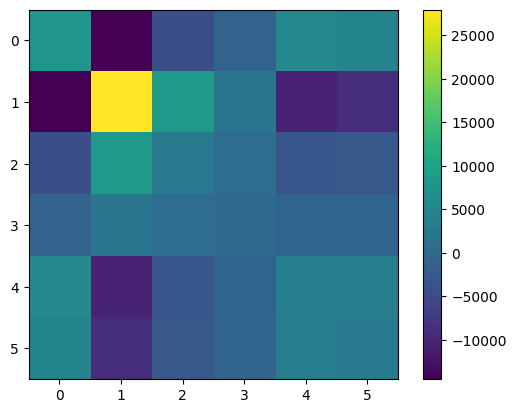

In [124]:
plt.imshow(fit_expr_flats.mean(0))
plt.colorbar()

In [2293]:
mdl_flats = jax.vmap(flatten_with_numerical_jacobian)(mdl_J, Fs)
frob_flats = jax.vmap(flatten_with_numerical_jacobian)(frob_J, Fs)

In [2294]:
mdl_flats.mean(0), frob_flats.mean(0)

(Array([[ 0.4446572 , -0.0254314 , -0.14529668, -0.09817883, -0.40770695,
         -0.30648595],
        [-0.0254314 ,  1.0958844 , -0.0229186 ,  0.0089845 ,  0.0363153 ,
         -0.20906697],
        [-0.14529668, -0.0229186 ,  1.2868999 ,  0.1450612 , -0.3225845 ,
         -0.10573426],
        [-0.09817884,  0.0089845 ,  0.1450612 ,  1.1866338 , -0.2551841 ,
          0.05284588],
        [-0.40770692,  0.0363153 , -0.3225845 , -0.2551841 ,  0.80699086,
         -0.07005166],
        [-0.30648598, -0.20906697, -0.10573427,  0.05284588, -0.07005166,
          1.4936527 ]], dtype=float32),
 Array([[ 0.35951105, -0.09145447, -0.18114378, -0.10509501, -0.38763705,
         -0.09457854],
        [-0.09145447,  1.0789019 , -0.06917822, -0.03053624, -0.04625257,
         -0.2948182 ],
        [-0.18114378, -0.06917822,  1.2639962 ,  0.12971012, -0.32074058,
         -0.14674012],
        [-0.10509501, -0.03053624,  0.12971012,  1.1826932 , -0.25265875,
          0.05840683],
        [-0.3

In [2295]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [2296]:
#nn_flats = jax.vmap(jax.vmap(flatten_with_numerical_jacobian))(dys, ensemble_Fs).mean(0)

nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)

In [2297]:
Fs, dy

(array([[[ 1.27920574e-02, -3.42082717e-02, -1.13004481e-03,
          -4.90475111e-02, -6.58291811e-03, -5.28474711e-03],
         [-3.42082717e-02,  1.37877488e+00,  4.75072861e-02,
           7.31811896e-02,  1.80283590e-04,  4.97958027e-02],
         [-1.13004481e-03,  4.75072861e-02,  2.72833169e-01,
          -1.42118990e-01, -1.82714183e-02,  1.83415494e-03],
         [-4.90475111e-02,  7.31811896e-02, -1.42118990e-01,
           3.01991749e+01,  1.41651481e-02, -2.93586683e-02],
         [-6.58291811e-03,  1.80283590e-04, -1.82714183e-02,
           1.41651481e-02,  9.69208717e-01, -1.83330458e-02],
         [-5.28474711e-03,  4.97958027e-02,  1.83415494e-03,
          -2.93586683e-02, -1.83330458e-02,  9.56690907e-01]],
 
        [[ 1.31420046e-02, -3.21872234e-02, -6.31421525e-03,
          -7.12909084e-03, -9.87916719e-04, -6.00713119e-03],
         [-3.21872234e-02,  1.30011678e+00,  4.39455844e-02,
           1.14235699e-01,  1.47403369e-03,  1.93124022e-02],
         [-6.

In [2298]:
nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)
nn_flats.mean(0)

Array([[ 1.0705967 ,  0.02923882,  0.0164151 ,  0.02902345,  0.03165403,
        -0.00639825],
       [ 0.02923883,  1.0532969 , -0.02651536, -0.00620847,  0.00335143,
         0.00226884],
       [ 0.0164151 , -0.02651536,  1.068052  ,  0.04488024,  0.01248531,
        -0.01802492],
       [ 0.02902345, -0.00620847,  0.04488024,  1.0615776 ,  0.02018866,
        -0.03641403],
       [ 0.03165404,  0.00335143,  0.01248531,  0.02018866,  1.0410988 ,
        -0.0148805 ],
       [-0.00639825,  0.00226884, -0.01802492, -0.03641403, -0.0148805 ,
         1.0637051 ]], dtype=float32)

In [2299]:
frob_coordinates, mdl_coordinates

(['((-0.000000) + (0.999965 * ((((-0.255094) * X5) + (-1.221468)) + (exp((0.186045 * X4)) + (0.504562 * X6)))))',
  '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166 * X4) + (0.056009 * X5))) + (0.921615 * X2))))))',
  '((-2.175624) + (0.852304 * (((0.657605 * X5) + exp(exp(((-1.207325) * X4)))) + ((0.243478 * X2) + sqrt((0.180595 * X3))))))',
  '((-0.001738) + (0.635467 * (((exp(((-1.170022) * X4)) + ((-0.771097) * X6)) + (0.516828 * X3)) + ((-0.927204) * X5))))',
  '((-0.078065) + (0.810098 * (((exp(((-0.532319) * X4)) + (((-0.496046) * X3) + ((-0.492361) * X2))) + ((-0.645588) * X6)) + (0.258904 * X5))))',
  '(0.420809 + ((-1.704589) * ((0.146736 * X6) + (((-0.189094) * X5) + (((-0.210490) * X3) + exp(((-2.478137) * X4)))))))'],
 ['((-0.000000) + (1.000000 * ((((0.204857 * X4) + ((-0.256810) * X5)) + (0.505997 * X6)) + ((0.165010 * X2) + (-0.308194)))))',
  '((-0.766542) + (1.005450 * (((-0.146338) * X3) + (((-0.279673) * X6) + (sqrt(((0.516166

In [2300]:
evalues_nn = jax.vmap(get_evalues)(nn_flats)
evalues_mdl = jax.vmap(get_evalues)(mdl_flats)
evalues_frob = jax.vmap(get_evalues)(frob_flats)

evalues_fitexpr = jax.vmap(get_evalues)(fit_expr_flats)

In [2301]:
evalues_fitexpr

Array([[-1.4934011e-07,  3.9814893e-08,  2.3878138e-07,  6.8404421e-05,
         2.0049732e+00,  3.1840017e+00],
       [-5.7849075e-08,  6.5302608e-08,  2.5227649e-07,  5.6089273e-05,
         1.7155445e+00,  2.6003814e+00],
       [-2.5478818e-07, -5.1836906e-08,  1.7924311e-08,  4.9757866e-05,
         1.9253552e+00,  3.0618205e+00],
       ...,
       [-2.5755654e-07, -5.8754122e-08,  4.5942780e-08,  1.2086174e-04,
         1.7007815e+00,  2.9792445e+00],
       [-6.6431134e-08,  2.1109742e-07,  3.1374967e-07,  9.2285467e-05,
         1.5203042e+00,  2.8148050e+00],
       [-3.4927091e-08,  9.1366111e-08,  4.9156404e-07,  5.0378861e-05,
         1.7774717e+00,  2.7689683e+00]], dtype=float32)

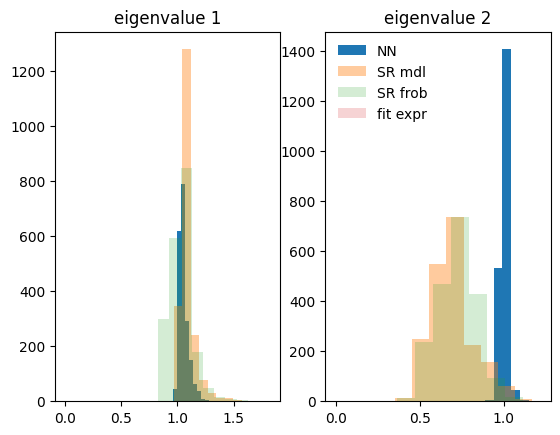

In [2302]:
plt.subplot(121)
plt.title("eigenvalue 1")

plt.hist(evalues_nn[:, 3], label="NN")
plt.hist(evalues_mdl[:, 3], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 3], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 3], alpha=0.2, label="fit expr")


plt.subplot(122)
plt.title("eigenvalue 2")
plt.hist(evalues_nn[:, 1], label="NN")
plt.hist(evalues_mdl[:, 1], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 1], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 1], alpha=0.2, label="fit expr")


plt.legend(framealpha=0.0)

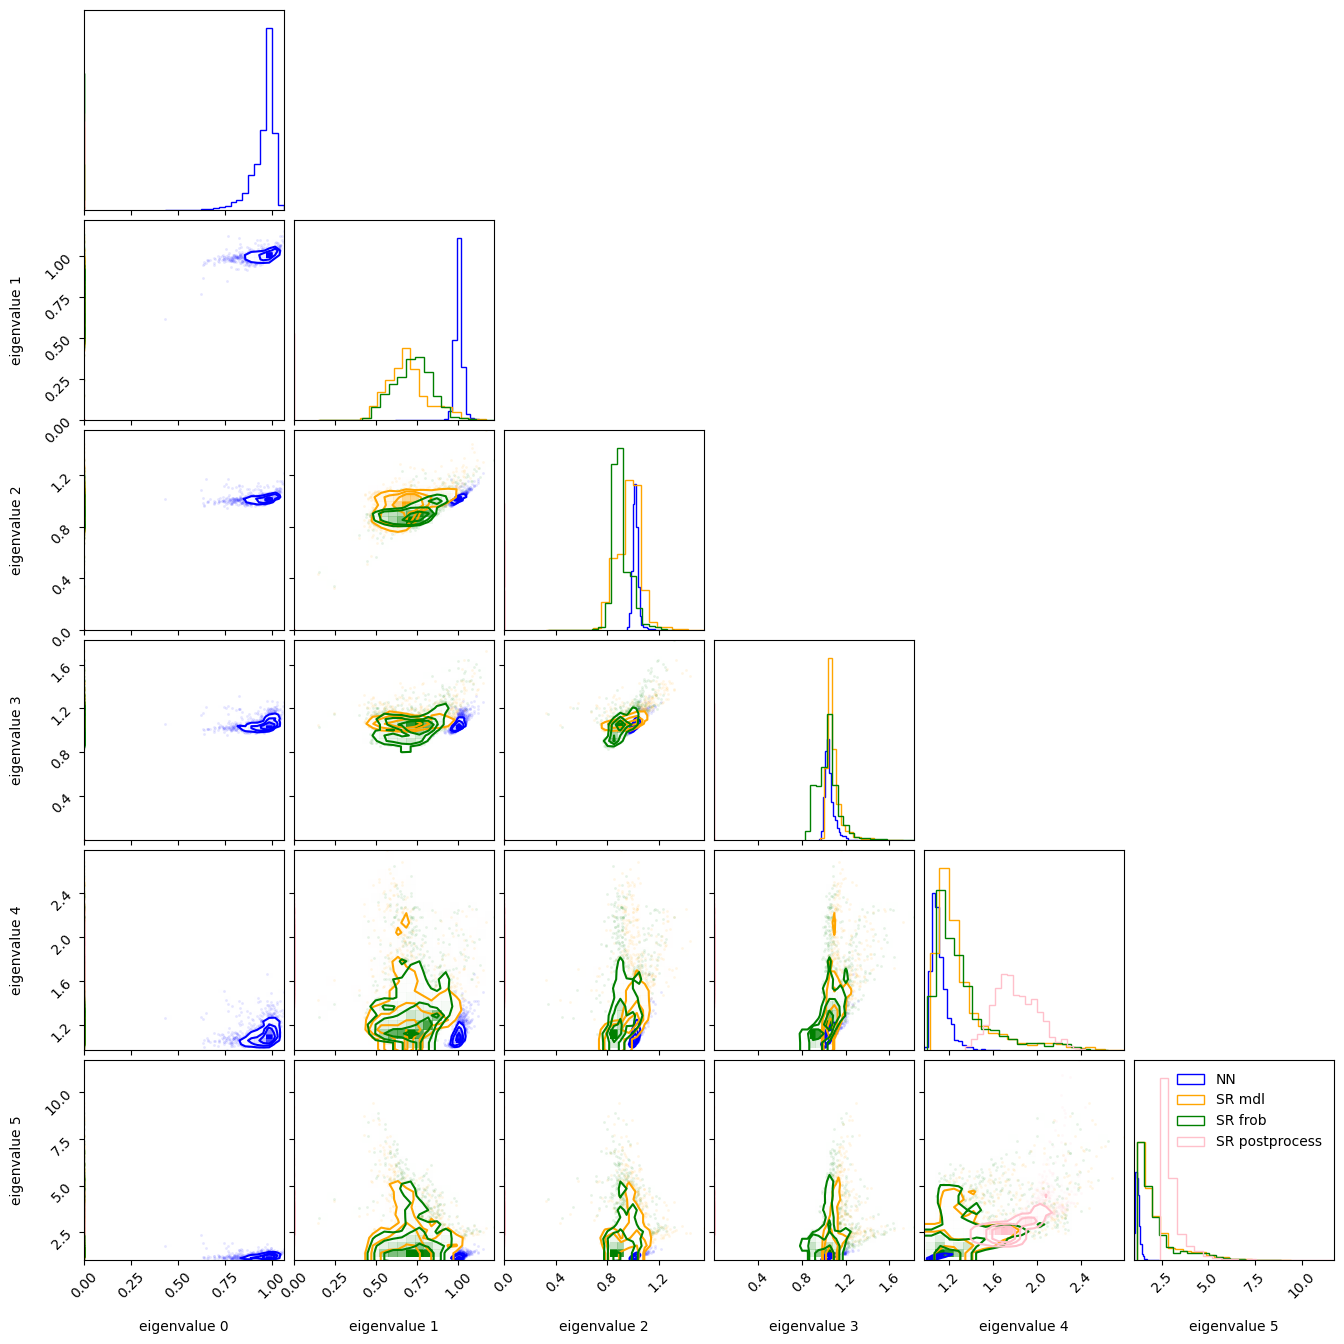

In [2303]:
import corner

cols = ['eigenvalue %d'%(i) for i in range(6)]

figure = corner.corner(np.array(evalues_nn), color="blue", labels=cols, hist_kwargs=dict(label="NN"))
figure = corner.corner(np.array(evalues_mdl), color="orange", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR mdl"))
figure = corner.corner(np.array(evalues_frob), color="green", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR frob"))
figure = corner.corner(np.array(evalues_fitexpr), color="pink", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR postprocess"))


plt.legend(framealpha=0.0)


In [ ]:
nn_flats

Array([[[ 1.0772775 , -0.01535606, -0.01995462,  0.01070714,
         -0.03406739,  0.008757  ],
        [-0.01535594,  1.117358  ,  0.00660574,  0.00188088,
          0.02381819, -0.00837278],
        [-0.01995343,  0.00660622,  1.0975267 ,  0.00563586,
          0.02832937, -0.03974009],
        [ 0.01070654,  0.00188106,  0.00563556,  1.0907335 ,
         -0.03539801, -0.02120137],
        [-0.03406882,  0.02381837,  0.02832913, -0.03539848,
          1.126172  ,  0.00748253],
        [ 0.0087558 , -0.00837305, -0.03974038, -0.02120221,
          0.00748235,  1.0525061 ]],

       [[ 0.9842515 , -0.09211445,  0.08058959, -0.05499971,
         -0.10733807, -0.06834543],
        [-0.09211451,  1.0684648 , -0.09053814, -0.02913451,
          0.10700394,  0.00403516],
        [ 0.08058868, -0.09053797,  1.1276433 , -0.10924208,
         -0.13406408, -0.01252759],
        [-0.05499938, -0.02913213, -0.10924083,  1.1069845 ,
          0.01149607, -0.08918715],
        [-0.10733736,  0.107

TypeError: arctan2() takes from 2 to 3 positional arguments but 6 were given

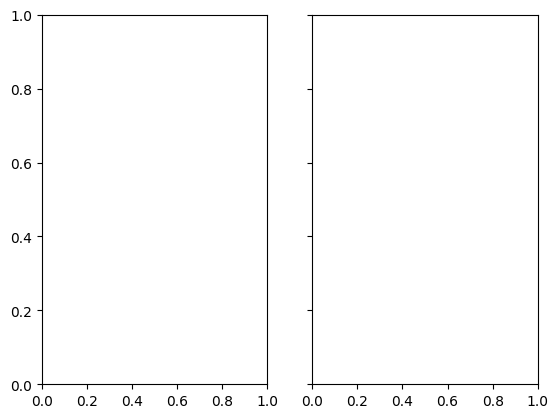

In [2209]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 2, sharey=True) 


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")

ax.set_box_aspect(1)


plt.legend()

#plt.tight_layout()

In [ ]:
datafile['norm_factor']

array(50.)

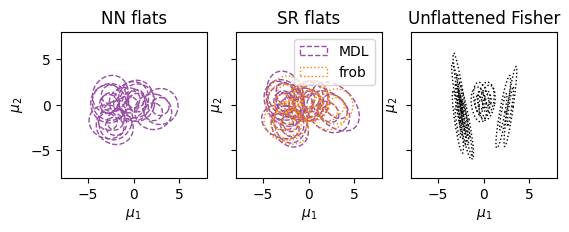

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r]*50,ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r]*datafile['norm_factor'] / 10., mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("Unflattened Fisher")
ax.set_box_aspect(1)



#plt.tight_layout()

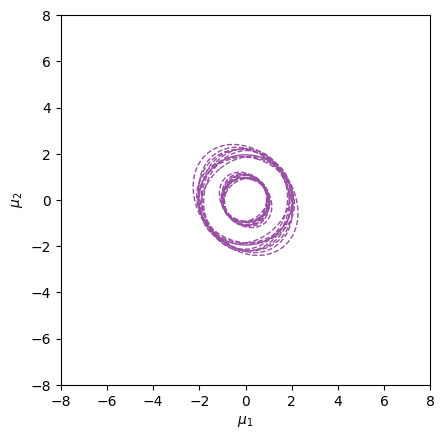

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8, 8)
ax.set_box_aspect(1)
#plt.legend()

In [ ]:
Fs * 50

array([[[ 57.03193  ,  10.4556055],
        [ 10.4556055,  17.953815 ]],

       [[436.8714   ,  75.04839  ],
        [ 75.04839  ,  14.848278 ]],

       [[380.1232   ,  72.68779  ],
        [ 72.68779  ,  16.019688 ]],

       ...,

       [[398.75772  ,  75.044304 ],
        [ 75.044304 ,  16.217165 ]],

       [[343.41068  , -60.79675  ],
        [-60.79675  ,  12.904592 ]],

       [[331.821    , -61.36552  ],
        [-61.36552  ,  13.351655 ]]], dtype=float32)

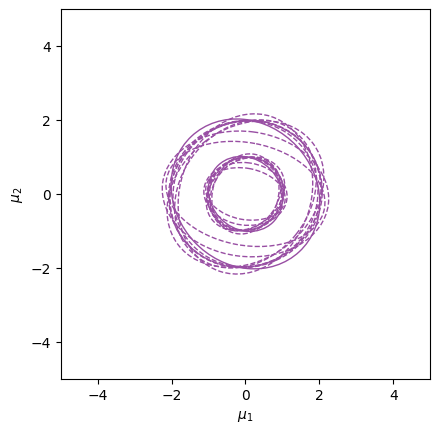

In [ ]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()

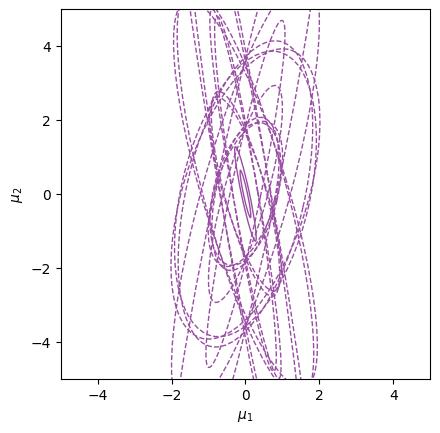

In [ ]:
# plot a smattering of fishers

#randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r] * 50, mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5,5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()